Final Project - Pisa Data Analysis
Authors: Karl, Hannah, and Siobhan
207


In [1]:
import numpy as np
import pandas as pd
# pd.options.display.float_format = '{:,.2f}'.format
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import re
get_ipython().run_line_magic('matplotlib', 'inline')

import numpy as np
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm
import math

import time
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures


import graphviz 
from sklearn import tree

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from keras.models import Sequential 
from keras.layers import Dense, Activation
from keras import optimizers

import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
print (theano.config.device) # We're using CPUs (for now)
print (theano.config.floatX) # Should be 64 bit for CPUs

C:\Users\Siobhan\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Siobhan\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\Siobhan\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inn

cpu
float64


In [3]:
def pisa_parser(filepath, filepath_out, bunchsize=1000):
    '''A parser which removes the brackets and single quotes from the file and writes it to a new file'''
    
    bunch = []
    with open(filepath) as r, open(filepath_out, "w") as w:
        for line in r:
            # Remove starting bracket, ending bracket, single quotes, and new lines
            cleaned_line = re.sub(pattern=r'^(\[)|(\])$|\'',
                                  repl='',
                                  string=line)
            
            # Remove spaces befor or after commas
            cleaned_line = re.sub(pattern=r'\s*,\s*',
                                  repl=',',
                                  string=cleaned_line)
            
            bunch.append(cleaned_line)
            if len(bunch) > bunchsize:
                w.writelines(bunch)
                bunch = []
                
        # Write the last bunch of lines outside the loop
        w.writelines(bunch)
        print(f'Successfully Wrote to {filepath_out}!')

In [4]:
# Only run the pisa parser if a cleaned data set is not available
try:
    pisa_usa_unique = pd.read_csv('pisa_usa_unique.csv', na_values='None')

except FileNotFoundError:
    #pisa_parser('qqq.dat', 'cleaned_qqq.csv')
    pisa = pd.read_csv('cleaned_qqq.csv', na_values='None')
    # Read the first line to get the column names
    pisa_columns = [col.lower() for col in pisa.columns]
    # Rename the columns    
    pisa.columns = pisa_columns
    pisa_usa = pisa[pisa['cnt'].isin(["USA", "QUC", "QUE", "QUD"])]
    # Find the columns with unique values
    pisa_usa_unique_cols = pisa_usa.apply(pd.Series.nunique)
    # Remove columns that have all 1 value or all NAs
    pisa_usa_unique_cols = pisa_usa_unique_cols[pisa_usa_unique_cols > 1]
    pisa_usa_unique = pisa_usa.loc[:,pisa_usa_unique_cols.index]
    pisa_usa_unique.to_csv('pisa_usa_unique.csv')


In [5]:
#Cut up the data into parts
usa = pisa_usa_unique
#usa = usa.reset_pisa_usa_uniqueindex(drop=True)
usa_math = usa[['pv1math','pv2math', 'pv3math', 'pv4math', 'pv5math', 'pv6math', 'pv7math', 'pv8math', 'pv9math', 'pv10math']]
usa_read = usa[['pv1read','pv2read', 'pv3read', 'pv4read', 'pv5read', 'pv6read', 'pv7read', 'pv8read', 'pv9read', 'pv10read']]
usa_scie = usa[['pv1scie','pv2scie', 'pv3scie', 'pv4scie', 'pv5scie', 'pv6scie', 'pv7scie', 'pv8scie', 'pv9scie', 'pv10scie']]
pca = PCA(n_components=1)
pca.fit(usa_math)
y_usa_math=pd.DataFrame(pca.transform(usa_math))

pca.fit(usa_read)
y_usa_read=pd.DataFrame(pca.transform(usa_read))

pca.fit(usa_scie)
y_usa_scie=pd.DataFrame(pca.transform(usa_scie))

print(f"USA features shape: {usa.shape}")
print(f"USA Math label shape: {y_usa_math.shape}")
print(f"USA Reading label shape: {y_usa_read.shape}")
print(f"USA Scie label shape: {y_usa_scie.shape}")
print(f"PCA explained variance {pca.explained_variance_ratio_}")


USA features shape: (10649, 492)
USA Math label shape: (10649, 1)
USA Reading label shape: (10649, 1)
USA Scie label shape: (10649, 1)
PCA explained variance [0.9317725]


It is interesting to note that the PCA of the scores most closely ties to the science scores. 
It is also interesting to note that the scores are sometimes a negative correlation.

In [6]:
full_read = pd.concat([usa_math,y_usa_math], axis=1)
corr_matrix = full_read.corr()
corr_matrix


,pv1math,pv2math,pv3math,pv4math,pv5math,pv6math,pv7math,pv8math,pv9math,pv10math,0
pv1math,1.000000,0.876837,0.880329,0.880863,0.880218,0.879040,0.880667,0.878081,0.880472,0.879506,0.945009
pv2math,0.876837,1.000000,0.877681,0.879557,0.877404,0.877625,0.877341,0.875721,0.876346,0.874461,0.942393
pv3math,0.880329,0.877681,1.000000,0.880799,0.876952,0.876245,0.877979,0.878532,0.881370,0.879632,0.944127
pv4math,0.880863,0.879557,0.880799,1.000000,0.875356,0.878829,0.879551,0.878426,0.883860,0.880817,0.945253
pv5math,0.880218,0.877404,0.876952,0.875356,1.000000,0.875234,0.872834,0.877361,0.878423,0.876036,0.941785
pv6math,0.879040,0.877625,0.876245,0.878829,0.875234,1.000000,0.877960,0.878956,0.877881,0.878527,0.942824
pv7math,0.880667,0.877341,0.877979,0.879551,0.872834,0.877960,1.000000,0.879733,0.877543,0.877197,0.943188
pv8math,0.878081,0.875721,0.878532,0.878426,0.877361,0.878956,0.879733,1.000000,0.878395,0.881552,0.943771
pv9math,0.880472,0.876346,0.881370,0.883860,0.878423,0.877881,0.877543,0.878395,1.000000,0.879121,0.944444
pv10math,0.879506,0.874461,0.879632,0.880817,0.876036,0.878527,0.877197,0.881552,0.879121,1.000000,0.944063


In [7]:
full_read = pd.concat([usa_read,y_usa_read], axis=1)
corr_matrix = full_read.corr()
corr_matrix

,pv1read,pv2read,pv3read,pv4read,pv5read,pv6read,pv7read,pv8read,pv9read,pv10read,0
pv1read,1.000000,0.883505,0.886734,0.885801,0.884970,0.881990,0.882255,0.882545,0.884567,0.882538,-0.946812
pv2read,0.883505,1.000000,0.888049,0.883330,0.883288,0.879985,0.881671,0.881421,0.883343,0.883852,-0.946207
pv3read,0.886734,0.888049,1.000000,0.884936,0.883676,0.878306,0.884245,0.882954,0.885170,0.883339,-0.947176
pv4read,0.885801,0.883330,0.884936,1.000000,0.879986,0.880039,0.884736,0.880712,0.883813,0.885115,-0.946142
pv5read,0.884970,0.883288,0.883676,0.879986,1.000000,0.880010,0.883028,0.883588,0.884527,0.884707,-0.946021
pv6read,0.881990,0.879985,0.878306,0.880039,0.880010,1.000000,0.876825,0.881182,0.883753,0.881985,-0.943292
pv7read,0.882255,0.881671,0.884245,0.884736,0.883028,0.876825,1.000000,0.884621,0.881180,0.883552,-0.945310
pv8read,0.882545,0.881421,0.882954,0.880712,0.883588,0.881182,0.884621,1.000000,0.882061,0.881056,-0.945118
pv9read,0.884567,0.883343,0.885170,0.883813,0.884527,0.883753,0.881180,0.882061,1.000000,0.883146,-0.946344
pv10read,0.882538,0.883852,0.883339,0.885115,0.884707,0.881985,0.883552,0.881056,0.883146,1.000000,-0.946126


In [8]:
full_read = pd.concat([usa_scie,y_usa_scie], axis=1)
corr_matrix = full_read.corr()
corr_matrix

,pv1scie,pv2scie,pv3scie,pv4scie,pv5scie,pv6scie,pv7scie,pv8scie,pv9scie,pv10scie,0
pv1scie,1.000000,0.924559,0.926326,0.926290,0.924336,0.925017,0.924290,0.924909,0.925509,0.925174,0.966202
pv2scie,0.924559,1.000000,0.924762,0.925091,0.923130,0.922446,0.925032,0.922934,0.924647,0.924238,0.965175
pv3scie,0.926326,0.924762,1.000000,0.925502,0.922815,0.923903,0.924294,0.921343,0.923502,0.923488,0.965103
pv4scie,0.926290,0.925091,0.925502,1.000000,0.924874,0.924974,0.925860,0.925227,0.926241,0.925210,0.966543
pv5scie,0.924336,0.923130,0.922815,0.924874,1.000000,0.921744,0.922787,0.924364,0.923960,0.923633,0.964593
pv6scie,0.925017,0.922446,0.923903,0.924974,0.921744,1.000000,0.922329,0.922815,0.923709,0.922776,0.964420
pv7scie,0.924290,0.925032,0.924294,0.925860,0.922787,0.922329,1.000000,0.923691,0.924099,0.924019,0.965209
pv8scie,0.924909,0.922934,0.921343,0.925227,0.924364,0.922815,0.923691,1.000000,0.924165,0.924630,0.964918
pv9scie,0.925509,0.924647,0.923502,0.926241,0.923960,0.923709,0.924099,0.924165,1.000000,0.923792,0.965516
pv10scie,0.925174,0.924238,0.923488,0.925210,0.923633,0.922776,0.924019,0.924630,0.923792,1.000000,0.965137


Text(0.5,1,'Science')

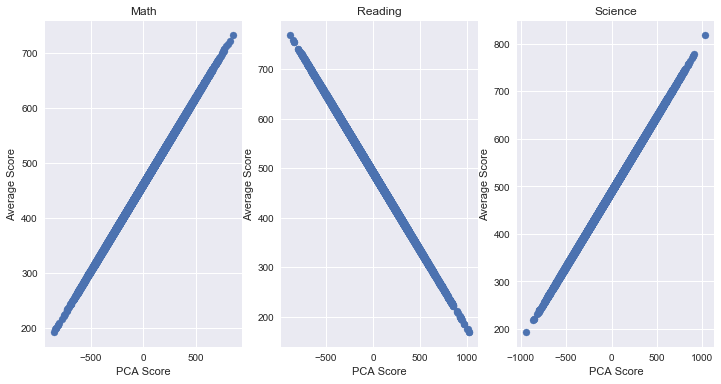

In [9]:
plt.figure(figsize=(12, 6))

avg_usa_math = usa_math.mean(axis =1)
avg_usa_math = pd.DataFrame(avg_usa_math)

plt.subplot(1, 3, 1)
plt.scatter(y_usa_math, avg_usa_math)
plt.ylabel("Average Score")
plt.xlabel("PCA Score")
plt.title("Math")

avg_usa_read = usa_read.mean(axis =1)
avg_usa_read = pd.DataFrame(avg_usa_read)

plt.subplot(1, 3, 2)
plt.scatter(y_usa_read, avg_usa_read)
plt.ylabel("Average Score")
plt.xlabel("PCA Score")
plt.title("Reading")

avg_usa_scie = usa_scie.mean(axis =1)
avg_usa_scie = pd.DataFrame(avg_usa_scie)

plt.subplot(1, 3, 3)
plt.scatter(y_usa_scie, avg_usa_scie)
plt.ylabel("Average Score")
plt.xlabel("PCA Score")
plt.title("Science")

Text(0.5,0,'Science')

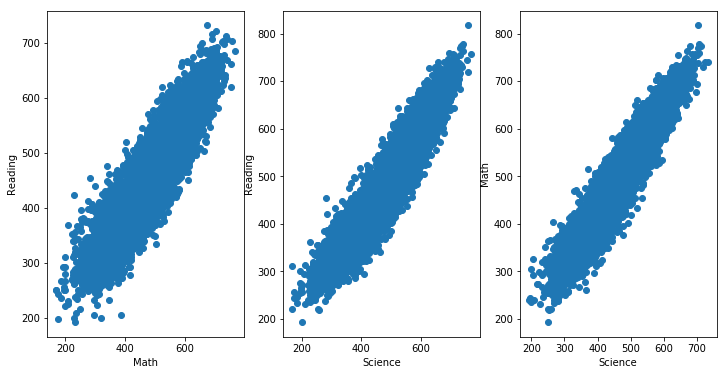

In [10]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(avg_usa_read, avg_usa_math)
plt.ylabel("Reading")
plt.xlabel("Math")

plt.subplot(1, 3, 2)
plt.scatter(avg_usa_read, avg_usa_scie)
plt.ylabel("Reading")
plt.xlabel("Science")

plt.subplot(1, 3, 3)
plt.scatter(avg_usa_math, avg_usa_scie)
plt.ylabel("Math")
plt.xlabel("Science")

In [12]:
# Cut into train, test, and dev

np.random.seed(0)  #  To ensure repeatability of results
shuffle = np.random.permutation(np.arange(usa.shape[0]))
X, Y1, Y2, Y3, Z1, Z2, Z3 = usa.iloc[shuffle], y_usa_math.iloc[shuffle], y_usa_read.iloc[shuffle],y_usa_scie.iloc[shuffle], avg_usa_math.iloc[shuffle], avg_usa_read.iloc[shuffle], avg_usa_scie.iloc[shuffle]
usa.shape

print ('data shape: ', X.shape)
print ('label shape:', Y1.shape)

# Set some variables to hold test, dev, and training data.

test_data,test_labels_math,test_labels_read,test_labels_scie,test_avg_math,test_avg_read,test_avg_scie = X[8000:], Y1[8000:], Y2[8000:], Y3[8000:], Z1[8000:], Z2[8000:], Z3[8000:]
dev_data,dev_labels_math,dev_labels_read,dev_labels_scie, dev_avg_math, dev_avg_read,dev_avg_scie =  X[6000:8000], Y1[6000:8000],Y2[6000:8000],Y3[6000:8000], Z1[6000:8000], Z2[6000:8000], Z3[6000:8000]
train_data,train_labels_math,train_labels_read,train_labels_scie,train_avg_math,train_avg_read,train_avg_scie = X[:6000], Y1[:6000], Y2[:6000], Y3[:6000], Z1[:6000], Z2[:6000], Z3[:6000]


data shape:  (10649, 492)
label shape: (10649, 1)


After reading the PISA data manual, we realized that a lot of the survey data analysis had been done for us
in derived fields.  ESCS is a PCA field but the other fields map to 1-3 questions.



http://www.oecd.org/pisa/pisaproducts/pisadataanalysismanualspssandsassecondedition.htm

In [13]:
#create the datasets with important columns
usa_train_data = train_data[['cbasci','bookid','age','disclisci',
'teachsup','ibteach','bsmj','grade','immig','repeat','durecec',
'outhours','lmins','tmins','belong','anxtest','motivat','cooperate',
'cpsvalue','emosups','perfeed','adinst','unfairteacher','cobn_f',
'cobn_m','cobn_s','langn','ocod3','escs']].copy()


usa_test_data = test_data[['cbasci','bookid','age','disclisci',
'teachsup','ibteach','bsmj','grade','immig','repeat','durecec',
'outhours','lmins','tmins','belong','anxtest','motivat','cooperate',
'cpsvalue','emosups','perfeed','adinst','unfairteacher','cobn_f',
'cobn_m','cobn_s','langn','ocod3','escs']].copy()

usa_dev_data = dev_data[['cbasci','bookid','age','disclisci',
'teachsup','ibteach','bsmj','grade','immig','repeat','durecec',
'outhours','lmins','tmins','belong','anxtest','motivat','cooperate',
'cpsvalue','emosups','perfeed','adinst','unfairteacher','cobn_f',
'cobn_m','cobn_s','langn','ocod3','escs']].copy()

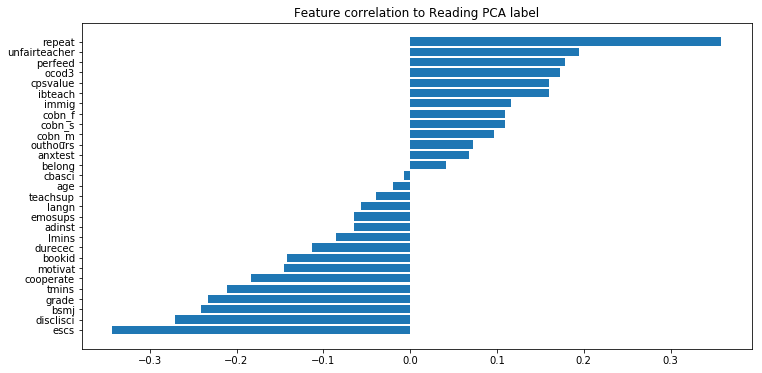

In [14]:
def plot_corr_barh(dataframe, title):
    '''Display a hbar graph for the correlation to the PCA variable.'''
    corr_matrix = dataframe.corr()
    corr_matrix=corr_matrix.sort_values([0], ascending=True)
    corr_matrix.drop([0], inplace=True)

    plt.figure(figsize=(12, 6))
    plt.barh(np.arange(len(corr_matrix[0].index)), 
            width=corr_matrix[0],
            tick_label=corr_matrix[0].index)
    plt.title(title)

plot_corr_barh(pd.concat([usa_train_data,y_usa_read], axis=1),
               'Feature correlation to Reading PCA label')

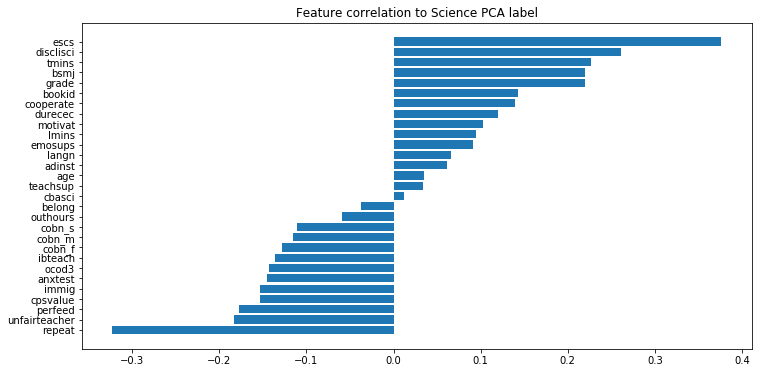

In [15]:
plot_corr_barh(pd.concat([usa_train_data,y_usa_scie], axis=1),
               'Feature correlation to Science PCA label')

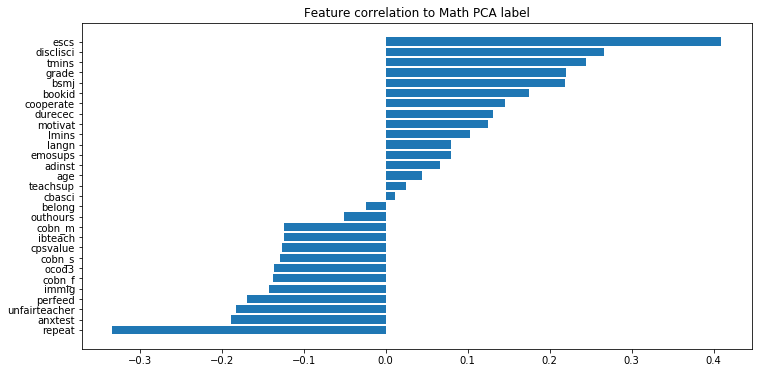

In [16]:
plot_corr_barh(pd.concat([usa_train_data,y_usa_math], axis=1),
               'Feature correlation to Math PCA label')

In [14]:
full_read = pd.concat([usa_train_data,y_usa_read], axis=1)
corr_matrix = full_read.corr()
corr_matrix=corr_matrix.sort_values([0], ascending=False)
print("Reading")
corr_matrix[0]

Reading


0                1.000000
repeat           0.358306
unfairteacher    0.194082
perfeed          0.178518
ocod3            0.173069
cpsvalue         0.160238
ibteach          0.160207
immig            0.115901
cobn_f           0.109768
cobn_s           0.109719
cobn_m           0.097080
outhours         0.072538
anxtest          0.067561
belong           0.041055
cbasci          -0.006921
age             -0.020060
teachsup        -0.039692
langn           -0.056792
emosups         -0.064452
adinst          -0.064843
lmins           -0.085772
durecec         -0.112591
bookid          -0.142375
motivat         -0.145164
cooperate       -0.183234
tmins           -0.210738
grade           -0.233370
bsmj            -0.240689
disclisci       -0.270842
escs            -0.342997
Name: 0, dtype: float64

In [15]:
full_read = pd.concat([usa_train_data,y_usa_scie], axis=1)
corr_matrix = full_read.corr()
corr_matrix=corr_matrix.sort_values([0], ascending=False)
print("Science")
corr_matrix[0]

Science


0                1.000000
escs             0.376034
disclisci        0.260865
tmins            0.226475
bsmj             0.219848
grade            0.219703
bookid           0.143093
cooperate        0.138857
durecec          0.120137
motivat          0.102987
lmins            0.095104
emosups          0.091344
langn            0.066384
adinst           0.061155
age              0.034774
teachsup         0.033235
cbasci           0.012243
belong          -0.037093
outhours        -0.059693
cobn_s          -0.110686
cobn_m          -0.115026
cobn_f          -0.128210
ibteach         -0.136192
ocod3           -0.142659
anxtest         -0.145647
immig           -0.153515
cpsvalue        -0.153850
perfeed         -0.177688
unfairteacher   -0.183421
repeat          -0.322818
Name: 0, dtype: float64

In [16]:
full_read = pd.concat([usa_train_data,y_usa_math], axis=1)
corr_matrix = full_read.corr()
corr_matrix=corr_matrix.sort_values([0], ascending=False)
print("Math")
corr_matrix[0]

Math


0                1.000000
escs             0.409221
disclisci        0.266700
tmins            0.244057
grade            0.220282
bsmj             0.218234
bookid           0.174532
cooperate        0.145344
durecec          0.131019
motivat          0.125042
lmins            0.103355
langn            0.080106
emosups          0.079101
adinst           0.066227
age              0.044480
teachsup         0.024727
cbasci           0.010692
belong          -0.024444
outhours        -0.051229
cobn_m          -0.123920
ibteach         -0.124115
cpsvalue        -0.126572
cobn_s          -0.128971
ocod3           -0.136923
cobn_f          -0.137553
immig           -0.142879
perfeed         -0.169727
unfairteacher   -0.182645
anxtest         -0.188469
repeat          -0.333539
Name: 0, dtype: float64

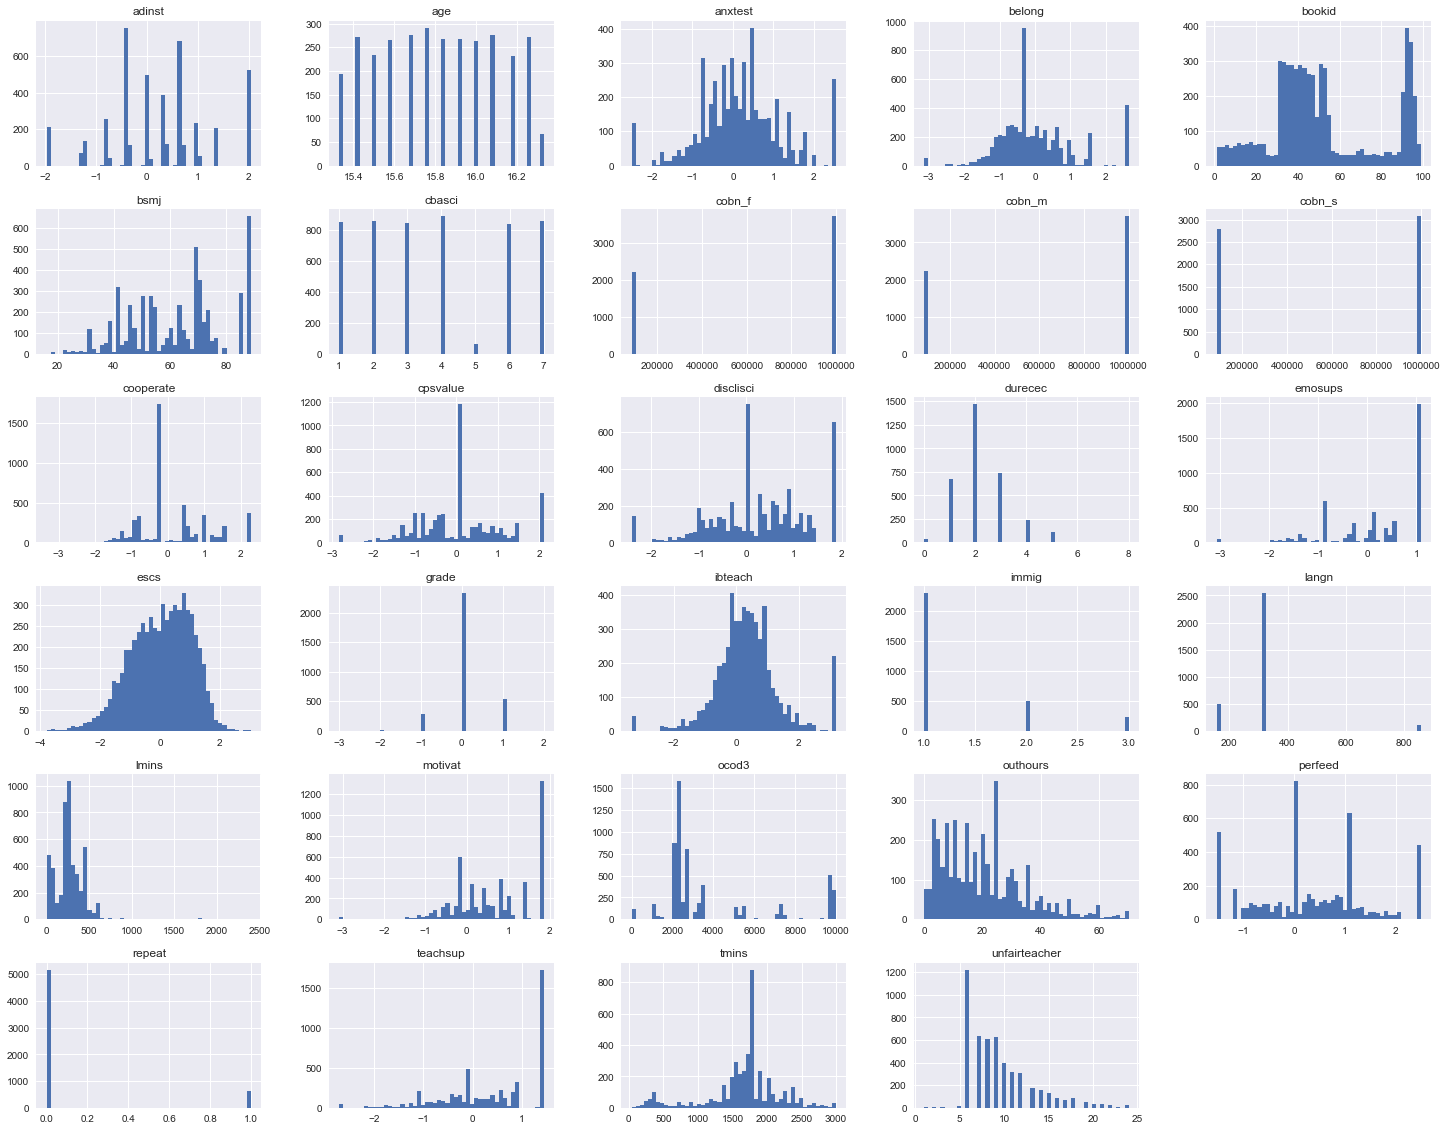

In [17]:
import matplotlib.pyplot as plt
usa_train_data.hist(bins=50, figsize=(25,20))
plt.show()

A lot of the data is actually already scaled in a -2 to +2 range. However, it is clear that the data is not normalized in a standard way.

In [18]:
usa_train_data.describe().loc[['min', 'max']].T

,min,max
cbasci,1.0000,7.0000
bookid,1.0000,99.0000
age,15.3300,16.3300
disclisci,-2.4162,1.8837
teachsup,-2.7195,1.4475
ibteach,-3.3405,3.1829
bsmj,16.0000,89.0000
grade,-3.0000,2.0000
immig,1.0000,3.0000
repeat,0.0000,1.0000


We initially created individual data files because some fields apply to only certain subjects like 'disclisci' 
indicates a discipline in science.  However, those fields seem to apply across the board.  This makes sense since
scores in different subjects are highly correlated.

In [19]:
#transform add column titles 
train_labels_scie.columns = ['score']
train_labels_math.columns = ['score']
train_labels_read.columns = ['score']

dev_labels_scie.columns = ['score']
dev_labels_math.columns = ['score']
dev_labels_read.columns = ['score']

test_labels_scie.columns = ['score']
test_labels_math.columns = ['score']
test_labels_read.columns = ['score']

train_avg_scie.columns = ['score']
train_avg_math.columns = ['score']
train_avg_read.columns = ['score']

dev_avg_scie.columns = ['score']
dev_avg_math.columns = ['score']
dev_avg_read.columns = ['score']

test_avg_scie.columns = ['score']
test_avg_math.columns = ['score']
test_avg_read.columns = ['score']

In [20]:
#see how many records there are for each column to ID the one with most NaN values.  This is important because empty fields will 
#cause an entire row to drop from a regression
usa_train_data.count()

cbasci           5199
bookid           6000
age              3176
disclisci        5426
teachsup         5388
ibteach          5347
bsmj             5167
grade            3176
immig            3045
repeat           5785
durecec          3285
outhours         4008
lmins            4890
tmins            4231
belong           5835
anxtest          5069
motivat          5066
cooperate        5049
cpsvalue         5048
emosups          5077
perfeed          5305
adinst           4446
unfairteacher    5050
cobn_f           5915
cobn_m           5953
cobn_s           5879
langn            3151
ocod3            6000
escs             5928
dtype: int64

In [21]:
def filter_na(data_file_in, label_file_in):
    '''Take data and label files are return them with no NA values.
    The "score" column is returned as the labels'''
    # transform training data 
    # join in the score data so it is filtered the same
    data_file_out = data_file_in.join(label_file_in)
    # drop rows that are not complete
    data_file_out  = data_file_out.dropna(how='any')
    label_file_out = data_file_out.pop('score')
    return (data_file_out, label_file_out)


In [22]:
#transform science data
train_data_nona, train_labels_nona_scie = filter_na(usa_train_data, train_labels_scie)
train_data_avgnona, train_labels_avgnona_scie = filter_na(usa_train_data, train_avg_scie)
test_data_nona, test_labels_nona_scie = filter_na(usa_test_data, test_labels_scie)
test_data_avgnona, test_labels_avgnona_scie = filter_na(usa_test_data, test_avg_scie)

#transform math data
train_data_nona, train_labels_nona_math = filter_na(usa_train_data, train_labels_math)
train_data_avgnona, train_labels_avgnona_math = filter_na(usa_train_data, train_avg_math)
test_data_nona, test_labels_nona_math = filter_na(usa_test_data, test_labels_math)
test_data_avgnona, test_labels_avgnona_math = filter_na(usa_test_data, test_avg_math)

#transform reading data
train_data_nona, train_labels_nona_read = filter_na(usa_train_data, train_labels_read)
train_data_avgnona, train_labels_avgnona_read = filter_na(usa_train_data, train_avg_read)
test_data_nona, test_labels_nona_read = filter_na(usa_test_data, test_labels_read)
test_data_avgnona, test_labels_avgnona_read = filter_na(usa_test_data, test_avg_read)


Text(0.5,1,'Histogram of Math PCA labels')

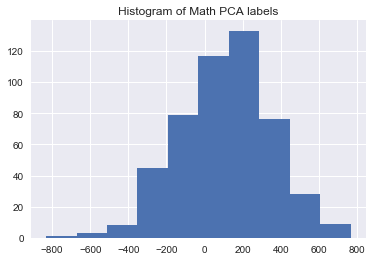

In [23]:
plt.hist(test_labels_nona_math)
plt.title('Histogram of Math PCA labels')

Text(0.5,1,'Histogram of Science PCA labels')

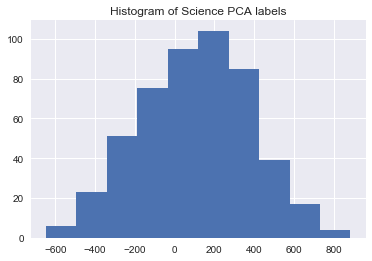

In [24]:
plt.hist(test_labels_nona_scie)
plt.title('Histogram of Science PCA labels')

Text(0.5,1,'Histogram of Reading PCA labels')

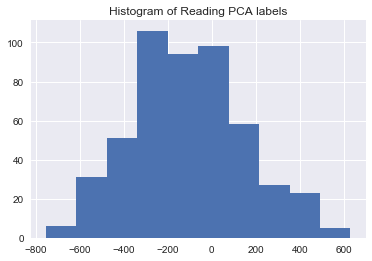

In [25]:
plt.hist(test_labels_nona_read )
plt.title('Histogram of Reading PCA labels')

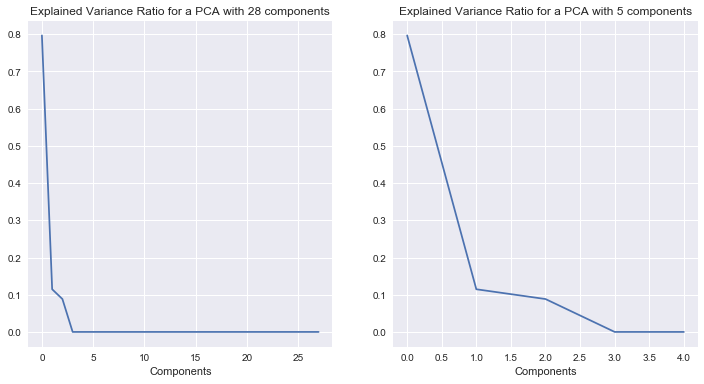

In [26]:
def PCA_check(comp1, comp2, X):
    ''''''
    plt.figure(figsize=(12, 6))

    pca_mod = PCA(n_components = comp1)
    pca_mod.fit(X)
    plt.subplot(1, 2, 1)
    plt.plot(pca_mod.explained_variance_ratio_)
    plt.title(f"Explained Variance Ratio for a PCA with {comp1} components")
    plt.xlabel('Components')


    pca_mod2 = PCA(n_components = comp2)
    pca_mod2.fit(X)
    plt.subplot(1, 2, 2)
    plt.plot(pca_mod2.explained_variance_ratio_)
    plt.title(f"Explained Variance Ratio for a PCA with {comp2} components")
    plt.xlabel('Components')
    
PCA_check(28, 5, train_data_nona)

In [30]:
###### Linear Regression

The R-squared value of this data is:  0.3655428626545898
The R-squared value of this data is:  0.36554099522440486


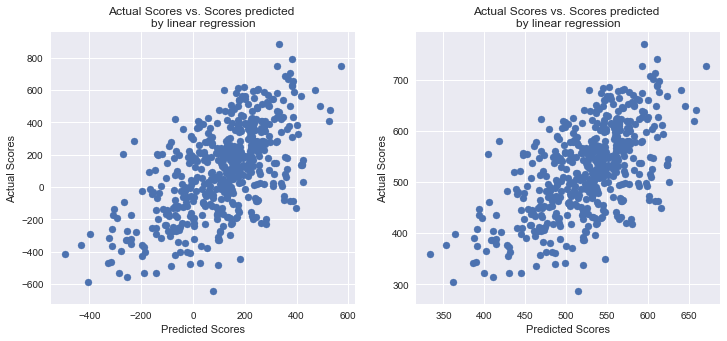

In [27]:
def lin_check1(X, X_score, Y, Y_score):
    '''Takes the training data and labels and the test data and labels
    to train a linear regression and plot the actual vs. predicted scores.
    the function returns the coeficents of the regression.
    '''
    reg = LinearRegression().fit(X, X_score)

    dev_predicted = reg.predict(Y)
    score1 = reg.score(Y, Y_score)
    print("The R-squared value of this data is: ", score1)
    plt.scatter(dev_predicted, Y_score)
    plt.ylabel("Actual Scores")
    plt.xlabel("Predicted Scores")
    plt.title('Actual Scores vs. Scores predicted \nby linear regression')
    return reg.coef_

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
sci_coefs = lin_check1(train_data_nona, train_labels_nona_scie, test_data_nona, test_labels_nona_scie)
plt.subplot(1,2,2)
sci_avg_coefs = lin_check1(train_data_avgnona, train_labels_avgnona_scie, test_data_avgnona, test_labels_avgnona_scie)


Below is the list of features sorted by the absolute value of the coefficient.  
This enables up to select the top 10 features from each model.

In [28]:
sci_coefs_df = pd.DataFrame(
    {'sci_coef': list(sci_coefs),
     'sci_avg_coef': list(sci_avg_coefs),
     'sci_col': list(train_data_nona.columns) 
    })
sci_coefs_df['sci_abs'] = abs(sci_coefs_df.sci_coef)
sci_coefs_df = sci_coefs_df.sort_values(['sci_abs'], ascending=False)
sci_coefs_df

,sci_avg_coef,sci_coef,sci_col,sci_abs
9,-37.392998,-118.263156,repeat,118.263156
28,20.003760,63.258205,escs,63.258205
18,-19.913911,-62.978457,cpsvalue,62.978457
20,-12.777444,-40.405001,perfeed,40.405001
17,12.142180,38.400305,cooperate,38.400305
3,11.385625,36.000128,disclisci,36.000128
21,10.810003,34.187244,adinst,34.187244
2,10.740489,33.993193,age,33.993193
7,9.624872,30.430237,grade,30.430237
15,-9.082913,-28.721776,anxtest,28.721776


The R-squared value of this data is:  0.35673167823751895
The R-squared value of this data is:  0.3567564186636621


Text(0.5,0.98,'Reading Regression')

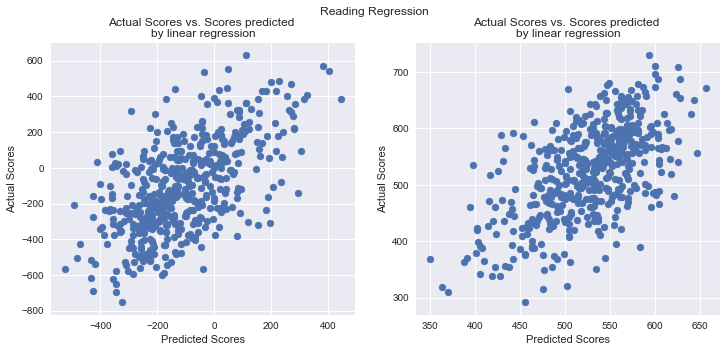

In [29]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
read_coefs = lin_check1(train_data_nona ,train_labels_nona_read, test_data_nona, test_labels_nona_read)
plt.subplot(1,2,2)
read_avg_coefs = lin_check1(train_data_avgnona ,train_labels_avgnona_read, test_data_avgnona, test_labels_avgnona_read)
plt.suptitle('Reading Regression')

In [30]:
read_coefs_df = pd.DataFrame(
    {'read_coef': list(read_coefs),
     'read_col': list(train_data_nona.columns),
     'read_avg_coef': list(read_avg_coefs),
    })
read_coefs_df['read_abs'] = abs(read_coefs_df.read_coef)
read_coefs_df=read_coefs_df.sort_values(['read_abs'], ascending=False)
read_coefs_df

,read_avg_coef,read_coef,read_col,read_abs
9,-41.579938,131.433787,repeat,131.433787
18,-20.296583,64.179008,cpsvalue,64.179008
17,17.370255,-54.929948,cooperate,54.929948
28,15.406846,-48.724493,escs,48.724493
20,-13.015206,41.150832,perfeed,41.150832
3,12.156141,-38.450472,disclisci,38.450472
21,8.967160,-28.351455,adinst,28.351455
7,8.961518,-28.344125,grade,28.344125
5,-8.089578,25.583746,ibteach,25.583746
16,7.252298,-22.947211,motivat,22.947211


The R-squared value of this data is:  0.4097431108869194
The R-squared value of this data is:  0.4097711983104249


Text(0.5,0.98,'Math Regression')

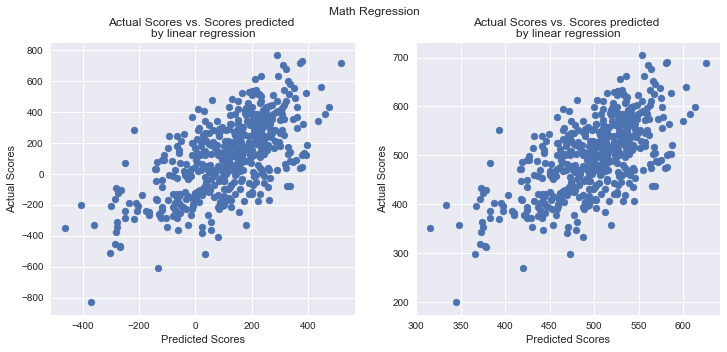

In [31]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
math_coefs = lin_check1(train_data_nona, train_labels_nona_math, test_data_nona, test_labels_nona_math)
plt.subplot(1,2,2)
math_avg_coefs = lin_check1(train_data_avgnona, train_labels_avgnona_math, test_data_avgnona, test_labels_avgnona_math)
plt.suptitle('Math Regression')

In [32]:
math_coefs_df = pd.DataFrame(
    {'math_coef': list(math_coefs),
     'math_col': list(train_data_nona.columns), 
     'math_avg_coef': list(math_avg_coefs),
    })
math_coefs_df['math_abs'] = abs(math_coefs_df.math_coef)
math_coefs_df=math_coefs_df.sort_values(['math_abs'], ascending=False)
math_coefs_df

,math_avg_coef,math_coef,math_col,math_abs
9,-35.760984,-113.119653,repeat,113.119653
28,20.500528,64.841804,escs,64.841804
18,-14.702254,-46.487000,cpsvalue,46.487000
2,12.483100,39.503990,age,39.503990
15,-12.064122,-38.161059,anxtest,38.161059
3,10.761558,34.028877,disclisci,34.028877
17,9.791122,30.943083,cooperate,30.943083
20,-9.769593,-30.897312,perfeed,30.897312
21,8.794640,27.810748,adinst,27.810748
7,6.272640,19.792473,grade,19.792473


Use only the top ten variables from each data set.  Most of the list repeats across test type.  Removed grade, immig, and age
since these fields have a low population rate.

In [33]:
#Experiement with limiting the dataset to high impact coefficients
#Note, i took out Age and grade because with the new data - it decimates our counts
#Rsquared looks ok

#create the  datasets
usa_train_data_sm = train_data[['disclisci', 'ibteach',
                                'repeat', 'perfeed', 'adinst',
                                'anxtest','cooperate', 'epist', 
                                'joyscie', 'envopt', 'cpsvalue', 'escs']].copy()


usa_test_data_sm = test_data[['disclisci', 'ibteach',
                              'repeat', 'perfeed', 'adinst',
                              'anxtest', 'cooperate', 'epist', 
                              'joyscie', 'envopt', 'cpsvalue', 'escs']].copy()

usa_dev_data_sm = dev_data[['disclisci', 'ibteach',
                            'repeat','perfeed', 'adinst',
                            'anxtest','cooperate','epist', 
                            'joyscie', 'envopt', 'cpsvalue','escs']].copy()

In [34]:
# Science
usa_train_data_sm_nona,  usa_train_label_scie_nona= filter_na(usa_train_data_sm, train_labels_scie)
usa_test_data_sm_nona,  usa_test_label_scie_nona=filter_na(usa_test_data_sm, test_labels_scie)
usa_train_data_sm_avgnona,  usa_train_label_scie_avgnona= filter_na(usa_train_data_sm, train_avg_scie)
usa_test_data_sm_avgnona,  usa_test_label_scie_avgnona=filter_na(usa_test_data_sm, test_avg_scie)

# Math
usa_train_data_sm_nona,  usa_train_label_math_nona= filter_na(usa_train_data_sm, train_labels_math)
usa_test_data_sm_nona,  usa_test_label_math_nona=filter_na(usa_test_data_sm, test_labels_math)
usa_train_data_sm_avgnona,  usa_train_label_math_avgnona= filter_na(usa_train_data_sm, train_avg_math)
usa_test_data_sm_avgnona,  usa_test_label_math_avgnona=filter_na(usa_test_data_sm, test_avg_math)

# Reading
usa_train_data_sm_nona,  usa_train_label_read_nona= filter_na(usa_train_data_sm, train_labels_read)
usa_test_data_sm_nona,  usa_test_label_read_nona=filter_na(usa_test_data_sm, test_labels_read)
usa_train_data_sm_avgnona,  usa_train_label_read_avgnona= filter_na(usa_train_data_sm, train_avg_read)
usa_test_data_sm_avgnona,  usa_test_label_read_avgnona=filter_na(usa_test_data_sm, test_avg_read)


In [35]:
def lin_check(X, X_score, Y, Y_score):
    '''Takes the training data and labels and the test data and labels
    to train a linear regression and print the R^2.
    the function returns the coeficents of the regression.
    '''
    reg = LinearRegression().fit(X, X_score)

    dev_predicted = reg.predict(Y)
    score1 = reg.score(Y, Y_score)
    print("The R-squared value of the data is: ",score1)
    return reg.coef_

print('Science and PCA Scores')
sci_coefs = lin_check(usa_train_data_sm_nona, usa_train_label_scie_nona ,usa_test_data_sm_nona, usa_test_label_scie_nona )
print('Science and Avg Scores')
sci_avg_coefs = lin_check(usa_train_data_sm_avgnona, usa_train_label_scie_avgnona ,usa_test_data_sm_avgnona, usa_test_label_scie_avgnona )

print('Math and PCA Scores')
math_coefs = lin_check(usa_train_data_sm_nona, usa_train_label_math_nona ,usa_test_data_sm_nona, usa_test_label_math_nona )
print('Math and Avg Scores')
math_avg_coefs = lin_check(usa_train_data_sm_avgnona, usa_train_label_math_avgnona ,usa_test_data_sm_avgnona, usa_test_label_math_avgnona )

print('Read and PCA Scores')
read_coefs = lin_check(usa_train_data_sm_nona, usa_train_label_read_nona ,usa_test_data_sm_nona, usa_test_label_read_nona )
print('Read and Avg Scores')
read_avg_coefs = lin_check(usa_train_data_sm_avgnona, usa_train_label_read_avgnona ,usa_test_data_sm_avgnona, usa_test_label_read_avgnona )

Science and PCA Scores
The R-squared value of the data is:  0.4099623935454161
Science and Avg Scores
The R-squared value of the data is:  0.4099586090432501
Math and PCA Scores
The R-squared value of the data is:  0.40210657138134887
Math and Avg Scores
The R-squared value of the data is:  0.4020673592741907
Read and PCA Scores
The R-squared value of the data is:  0.3985264429598069
Read and Avg Scores
The R-squared value of the data is:  0.39851120950199187


Not Bad! Now check out how our coefficients look... They all look pretty impactful.

In [44]:
def coefficients(col_names, coef):
    '''Return a dataframe of with the coeficients from a regression.
    '''
    col_names = list(col_names)
    coef = list(coef)

    return pd.DataFrame(coef, 
                        index=col_names,
                        columns=['Coefficients'])

coefficients(usa_train_data_sm_avgnona, math_avg_coefs)


,Coefficients
disclisci,12.004799
ibteach,-6.477923
repeat,-52.126851
perfeed,-15.494313
adinst,8.358173
anxtest,-12.318089
cooperate,6.350474
epist,13.854680
joyscie,8.751212
envopt,-9.194245


In [42]:
coefficients(usa_train_data_sm_nona, math_coefs)

,Coefficients
disclisci,37.956336
ibteach,-20.480429
repeat,-164.858997
perfeed,-48.995778
adinst,26.432463
anxtest,-38.963114
cooperate,20.070052
epist,43.808787
joyscie,27.681557
envopt,-29.085962


In [45]:
coefficients(usa_train_data_sm_avgnona, sci_avg_coefs)

,Coefficients
disclisci,13.059407
ibteach,-8.018573
repeat,-55.293713
perfeed,-18.584889
adinst,9.347164
anxtest,-10.118155
cooperate,7.584349
epist,17.866579
joyscie,14.141969
envopt,-11.902972


In [46]:
coefficients(usa_train_data_sm_nona, sci_coefs)

,Coefficients
disclisci,41.296817
ibteach,-25.357086
repeat,-174.853872
perfeed,-58.770520
adinst,29.557344
anxtest,-31.998816
cooperate,23.985211
epist,56.499787
joyscie,44.720805
envopt,-37.641368


In [48]:
coefficients(usa_train_data_sm_nona, read_avg_coefs)

,Coefficients
disclisci,14.061141
ibteach,-9.715855
repeat,-65.465968
perfeed,-17.666013
adinst,10.564200
anxtest,-3.349901
cooperate,14.430815
epist,17.181451
joyscie,7.592358
envopt,-11.626613


In [47]:
coefficients(usa_train_data_sm_nona, read_coefs)

,Coefficients
disclisci,-44.469545
ibteach,30.724530
repeat,207.031732
perfeed,55.859479
adinst,-33.401769
anxtest,10.594957
cooperate,-45.629600
epist,-54.333212
joyscie,-24.008241
envopt,36.764751


Text(0.5,1,'Histogram of the science labels')

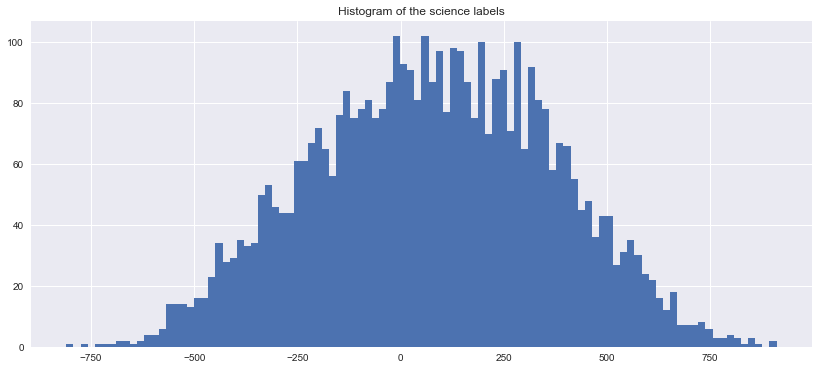

In [39]:
usa_train_label_scie_nona.hist(bins=100, figsize=[14,6])
plt.title('Histogram of the science labels')

Text(0.5,1,'Histogram of the math labels')

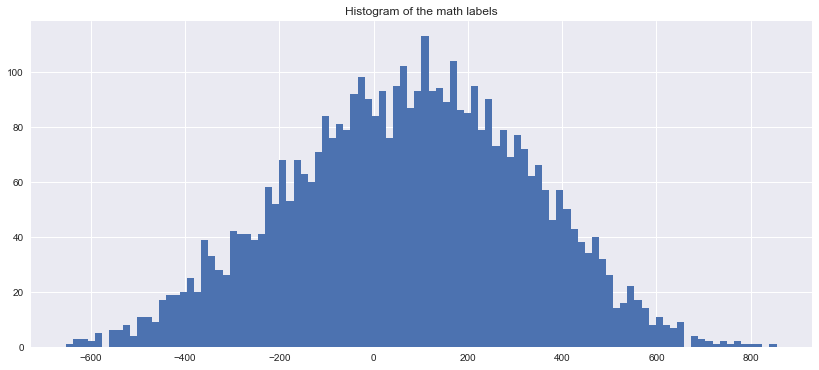

In [49]:
usa_train_label_math_nona.hist(bins=100, figsize=[14,6])
plt.title('Histogram of the math labels')

Text(0.5,1,'Histogram of the reading labels')

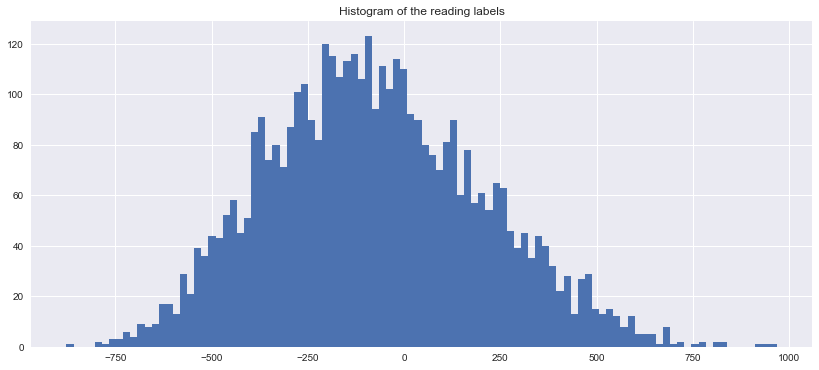

In [50]:
usa_train_label_read_nona.hist(bins=100, figsize=[14,6])
plt.title('Histogram of the reading labels')

In [51]:
#PCA stuff trial - not better R-squared

pca_mod33 = PCA(n_components = 10)
pca_mod33.fit(train_data_nona)

X3_pca = pca_mod33.transform(train_data_nona)
Y3_pca = pca_mod33.transform(test_data_nona)

PCA_math_coefs = lin_check(X3_pca,train_labels_nona_math, Y3_pca, test_labels_nona_math)

The R-squared value of the data is:  0.14117395107711173


Turn it into a classifier problem - note: the more bins you create- the lower the accuracy rate

In [52]:
data = np.random.random(100)
bins = np.linspace(-1000, 1000,4)
digi_train_label_scie = np.digitize(usa_train_label_scie_nona, bins) 
digi_train_label_math = np.digitize(usa_train_label_math_nona, bins) 
digi_train_label_read = np.digitize(usa_train_label_read_nona, bins) 

digi_test_label_scie = np.digitize(usa_test_label_scie_nona, bins) 
digi_test_label_math = np.digitize(usa_test_label_math_nona, bins) 
digi_test_label_read = np.digitize(usa_test_label_read_nona, bins) 

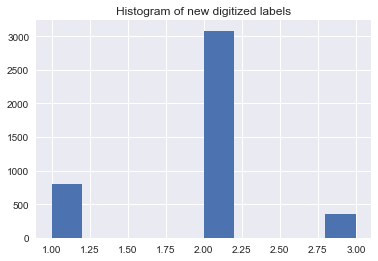

In [53]:
#conda install python-graphviz
plt.hist(digi_train_label_read)
plt.title('Histogram of new digitized labels')
plt.show()


In [54]:
##### test some more linear regression models, these don't seem to work but we are doing due diligence
clf = Ridge(alpha=1.0 , solver="cholesky")
clf.fit(usa_train_data_sm_nona, usa_train_label_scie_nona) 
predict = clf.predict(usa_test_data_sm_nona)

acc = np.mean((predict > usa_test_label_scie_nona - 200) & 
              (predict < usa_test_label_scie_nona + 200))

print(f'Science Accuracy Rate using Ridge {acc:.2%}')

Science Accuracy Rate using Ridge 64.18%


In [55]:
clf.fit(usa_train_data_sm_nona, usa_train_label_math_nona) 
predict = clf.predict(usa_test_data_sm_nona)

acc = np.mean((predict > usa_test_label_math_nona - 200) & 
              (predict < usa_test_label_math_nona + 200))

print(f'Math Accuracy Rate using Ridge {acc:.2%}')

Math Accuracy Rate using Ridge 69.94%


In [56]:
clf.fit(usa_train_data_sm_nona, usa_train_label_read_nona) 
predict = clf.predict(usa_test_data_sm_nona)

acc = np.mean((predict > usa_test_label_read_nona - 200) & 
              (predict < usa_test_label_read_nona + 200))

print(f'Reading Accuracy Rate using Ridge {acc:.2%}')

Reading Accuracy Rate using Ridge 66.72%


In [57]:
lasso = Lasso()
lasso.fit(usa_train_data_sm_nona, usa_train_label_scie_nona) 
predict = lasso.predict(usa_test_data_sm_nona)

acc = np.mean((predict > usa_test_label_scie_nona - 200) & (predict < usa_test_label_scie_nona + 200))

print(f'Science Accuracy Rate using Lasso {acc:.2%}')

Science Accuracy Rate using Lasso 64.13%


In [58]:
lasso = Lasso()
lasso.fit(usa_train_data_sm_nona, usa_train_label_math_nona) 
predict = lasso.predict(usa_test_data_sm_nona)

acc = np.mean((predict > usa_test_label_math_nona - 200) & (predict < usa_test_label_math_nona + 200))

print(f'Math Accuracy Rate using Lasso {acc:.2%}')

Math Accuracy Rate using Lasso 69.94%


In [59]:
lasso = Lasso()
lasso.fit(usa_train_data_sm_nona, usa_train_label_read_nona) 
predict = lasso.predict(usa_test_data_sm_nona)

acc = np.mean((predict > usa_test_label_read_nona - 200) & (predict < usa_test_label_read_nona + 200))

print(f'Reading Accuracy Rate using Lasso {acc:.2%}')

Reading Accuracy Rate using Lasso 66.83%


In [55]:
######################## Polynomial Regression ########################

In [60]:
def poly_f(x, x1, y1, x2, y2, desc):
    '''Fit a polynomial regression with a lasso.
    '''
    poly_features = PolynomialFeatures(degree=x, include_bias=False)
    X_poly = poly_features.fit_transform(x1)
    X2_poly = poly_features.transform(x2)
    lasso.fit(X_poly, y1)
    predict = lasso.predict(X2_poly)
    
    acc = np.mean((predict > y2 - 200) & (predict < y2 + 200))

    print(f'{desc} Accuracy Rate using Lasso - {x} degree: {acc:.2%}')


In [61]:
poly_f(2, usa_train_data_sm_nona, usa_train_label_scie_nona, usa_test_data_sm_nona, usa_test_label_scie_nona, 'Scie')
poly_f(2, usa_train_data_sm_nona, usa_train_label_math_nona, usa_test_data_sm_nona, usa_test_label_math_nona, 'Math')
poly_f(2, usa_train_data_sm_nona, usa_train_label_read_nona, usa_test_data_sm_nona, usa_test_label_read_nona, 'Read')

Scie Accuracy Rate using Lasso - 2 degree: 65.93%
Math Accuracy Rate using Lasso - 2 degree: 71.58%
Read Accuracy Rate using Lasso - 2 degree: 67.41%


In [62]:
poly_f(3, usa_train_data_sm_nona, usa_train_label_scie_nona, usa_test_data_sm_nona, usa_test_label_scie_nona, 'Scie')
poly_f(3, usa_train_data_sm_nona, usa_train_label_math_nona, usa_test_data_sm_nona, usa_test_label_math_nona, 'Math')
poly_f(3, usa_train_data_sm_nona, usa_train_label_read_nona, usa_test_data_sm_nona, usa_test_label_read_nona, 'Read')

Scie Accuracy Rate using Lasso - 3 degree: 65.98%
Math Accuracy Rate using Lasso - 3 degree: 71.05%
Read Accuracy Rate using Lasso - 3 degree: 67.62%


In [63]:
poly_f(4, usa_train_data_sm_nona, usa_train_label_scie_nona, usa_test_data_sm_nona, usa_test_label_scie_nona, 'Scie')
poly_f(4, usa_train_data_sm_nona, usa_train_label_math_nona, usa_test_data_sm_nona, usa_test_label_math_nona, 'Math')
poly_f(4, usa_train_data_sm_nona, usa_train_label_read_nona, usa_test_data_sm_nona, usa_test_label_read_nona, 'Read')

C:\Users\Siobhan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Scie Accuracy Rate using Lasso - 4 degree: 62.33%
Math Accuracy Rate using Lasso - 4 degree: 68.20%
Read Accuracy Rate using Lasso - 4 degree: 64.08%


In [60]:
####### logistic regression - F1 scores and confusion matrices

In [64]:
def helpind(inputfile, bottom_percentile):
    '''Label data that score in the bottom percentile with a 1
    '''
    x = pd.DataFrame(inputfile)
    x.columns = ['score']

    high_cutoff = np.percentile(x, bottom_percentile)
    
    outputfile = pd.DataFrame(inputfile)
    outputfile['helpind'] = np.where(x['score'] < high_cutoff, '1', '0')
    outputfile = outputfile.drop(['score'], axis=1)
    return(outputfile)


# Create labels for the bottom 25% in each subject
usa_train_scie_25 = helpind(usa_train_label_scie_avgnona, 25)
usa_train_math_25 = helpind(usa_train_label_math_avgnona, 25)
usa_train_read_25 = helpind(usa_train_label_read_avgnona, 25)

usa_test_scie_25 = helpind(usa_test_label_scie_avgnona, 25)
usa_test_math_25 = helpind(usa_test_label_math_avgnona, 25)
usa_test_read_25 = helpind(usa_test_label_read_avgnona, 25)

In [65]:
def log_reg(train_data, train_labels, dev_data, dev_labels):
    '''Train a logistic regression and return the predictions and
    an f1 score.
    '''
    logreg = LogisticRegression(C=0.5) #ran some manual tests, this had best accuracy
    train_labels = np.array(train_labels)
    dev_labels = np.array(dev_labels)
    logreg.fit(train_data, train_labels)
    pred = logreg.predict(dev_data)
    print(f"The f1-score is {metrics.f1_score(dev_labels, pred, average='micro')}")
    return pred


In [66]:
log_pred_scie25 = log_reg(usa_train_data_sm_avgnona, usa_train_scie_25, usa_test_data_sm_avgnona, usa_test_scie_25)
usa_test_scie_25 = np.array(usa_test_scie_25)
log_pred_scie = np.array(log_pred_scie25)
confusion_matrix(usa_test_scie_25, log_pred_scie)

The f1-score is 0.8108821975699947


C:\Users\Siobhan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[1320,  100],
       [ 258,  215]], dtype=int64)

In [67]:
log_pred_math25 = log_reg(usa_train_data_sm_avgnona,usa_train_math_25 , usa_test_data_sm_avgnona, usa_test_math_25)
usa_test_math_25 = np.array(usa_test_math_25)
log_pred_math = np.array(log_pred_math25 )
confusion_matrix(usa_test_math_25, log_pred_math)

The f1-score is 0.8166930797675647


C:\Users\Siobhan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[1329,   91],
       [ 256,  217]], dtype=int64)

In [68]:
log_pred_read25 = log_reg(usa_train_data_sm_avgnona,usa_train_read_25 , usa_test_data_sm_avgnona, usa_test_read_25)
usa_test_read_25 = np.array(usa_test_read_25)
log_pred_read = np.array(log_pred_read25 )
confusion_matrix(usa_test_read_25, log_pred_read)

The f1-score is 0.815108293713682


C:\Users\Siobhan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[1325,   95],
       [ 255,  218]], dtype=int64)

Logistic Regression with 50th percentile

In [69]:
usa_train_scie_50 = helpind(usa_train_label_scie_avgnona, 50)
usa_train_math_50 = helpind(usa_train_label_math_avgnona, 50)
usa_train_read_50 = helpind(usa_train_label_read_avgnona, 50)
usa_test_scie_50 = helpind(usa_test_label_scie_avgnona, 50)
usa_test_math_50 = helpind(usa_test_label_math_avgnona, 50)
usa_test_read_50 = helpind(usa_test_label_read_avgnona, 50)

In [70]:
log_pred_scie50 = log_reg(usa_train_data_sm_avgnona,usa_train_scie_50, usa_test_data_sm_avgnona, usa_test_scie_50)

usa_test_scie_50 = np.array(usa_test_scie_50)
log_pred_scie50 = np.array(log_pred_scie50)

confusion_matrix(usa_test_scie_50, log_pred_scie50)

The f1-score is 0.7242472266244057


C:\Users\Siobhan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[719, 228],
       [294, 652]], dtype=int64)

In [71]:
log_pred_math50 = log_reg(usa_train_data_sm_avgnona,usa_train_math_50 , usa_test_data_sm_avgnona, usa_test_math_50)

usa_test_math_50 = np.array(usa_test_math_50)
log_pred_math50 = np.array(log_pred_math50)

confusion_matrix(usa_test_math_50, log_pred_math50)

The f1-score is 0.7189646064447967


C:\Users\Siobhan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[718, 229],
       [303, 643]], dtype=int64)

In [72]:
log_pred_read50 = log_reg(usa_train_data_sm_avgnona,usa_train_read_50 , usa_test_data_sm_avgnona, usa_test_read_50)

usa_test_read_50 = np.array(usa_test_read_50)
log_pred_read50 = np.array(log_pred_read50)

confusion_matrix(usa_test_read_50, log_pred_read50)

The f1-score is 0.7242472266244057


C:\Users\Siobhan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[719, 228],
       [294, 652]], dtype=int64)

In [73]:
def helpindquart(inputfile):
    '''Label data 1, 2, 3, and 4 for each of the quartiles.
    '''
    x = pd.DataFrame(inputfile)
    outputfile = pd.DataFrame(inputfile)
    x.columns = ['score']
    cutoff_25 = np.percentile(x['score'], 25)
    cutoff_50 = np.percentile(x['score'], 50)
    cutoff_75 = np.percentile(x['score'], 75)
     
    outputfile['helpind'] = np.where(x['score'] > cutoff_25, '2', '1')
    outputfile['helpind'] = np.where(outputfile['score'] > cutoff_50, '3', outputfile['helpind'])
    outputfile['helpind'] = np.where(outputfile['score'] > cutoff_75, '4', outputfile['helpind'])    
    
    outputfile =outputfile.drop(['score'], axis=1)
    
    return(outputfile)


usa_train_scie_quart = helpindquart(usa_train_label_scie_avgnona)
usa_train_math_quart = helpindquart(usa_train_label_math_avgnona)
usa_train_read_quart = helpindquart(usa_train_label_read_avgnona)

usa_test_scie_quart = helpindquart(usa_test_label_scie_avgnona)
usa_test_math_quart = helpindquart(usa_test_label_math_avgnona)
usa_test_read_quart = helpindquart(usa_test_label_read_avgnona)



In [74]:
log_pred_sciequart = log_reg(usa_train_data_sm_avgnona,usa_train_scie_quart, usa_test_data_sm_avgnona, usa_test_scie_quart)

usa_test_scie_quart = np.array(usa_test_scie_quart)
log_pred_sciequart = np.array(log_pred_sciequart)

confusion_matrix(usa_test_scie_quart, log_pred_sciequart)


The f1-score is 0.4595879556259905


C:\Users\Siobhan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[331,  61,  39,  43],
       [171,  89, 116,  97],
       [ 81,  90, 113, 189],
       [ 30,  32,  74, 337]], dtype=int64)

In [75]:
log_pred_mathquart = log_reg(usa_train_data_sm_avgnona,usa_train_math_quart , usa_test_data_sm_avgnona, usa_test_math_quart)

usa_test_math_quart = np.array(usa_test_math_quart)
log_pred_mathquart = np.array(log_pred_mathquart)

confusion_matrix(usa_test_math_quart, log_pred_mathquart)


The f1-score is 0.4643423137876387


C:\Users\Siobhan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[337,  65,  36,  36],
       [147, 107, 105, 114],
       [ 73,  86,  98, 216],
       [ 36,  48,  52, 337]], dtype=int64)

In [76]:
log_pred_readquart = log_reg(usa_train_data_sm_avgnona,usa_train_read_quart , usa_test_data_sm_avgnona, usa_test_read_quart)

usa_test_read_quart = np.array(usa_test_read_quart)
log_pred_readquart = np.array(log_pred_readquart)

confusion_matrix(usa_test_scie_quart, log_pred_readquart)


The f1-score is 0.4474379292128896


C:\Users\Siobhan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[324,  62,  47,  41],
       [178,  75, 107, 113],
       [ 85,  78, 108, 202],
       [ 35,  28,  68, 342]], dtype=int64)

In [77]:
##### SVM model###############################################################################
#Start with Quartiles
from sklearn.svm import SVC
clf1 = SVC(gamma='auto', probability=True)

In [78]:
clf1.fit(usa_train_data_sm_avgnona,usa_train_scie_quart)
log_pred_sciequart = clf1.predict( usa_test_data_sm_avgnona) 
print('The f1-score is ', metrics.f1_score(usa_test_scie_quart, log_pred_sciequart, average='micro'))
confusion_matrix(usa_test_scie_quart, log_pred_sciequart)

C:\Users\Siobhan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The f1-score is  0.46909667194928684


array([[296,  97,  57,  24],
       [128, 127, 162,  56],
       [ 53, 104, 184, 132],
       [ 25,  41, 126, 281]], dtype=int64)

In [79]:
clf1.fit(usa_train_data_sm_avgnona,usa_train_math_quart)
log_pred_mathquart = clf1.predict( usa_test_data_sm_avgnona) 
print('The f1-score is ', metrics.f1_score(usa_test_math_quart, log_pred_mathquart, average='micro'))
confusion_matrix(usa_test_math_quart, log_pred_mathquart)

C:\Users\Siobhan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The f1-score is  0.47649234020073955


array([[302, 101,  50,  21],
       [107, 154, 152,  60],
       [ 54, 108, 167, 144],
       [ 30,  55, 109, 279]], dtype=int64)

In [80]:
clf1.fit(usa_train_data_sm_avgnona,usa_train_read_quart)
log_pred_readquart = clf1.predict( usa_test_data_sm_avgnona) 
print('The f1-score is ', metrics.f1_score(usa_test_read_quart, log_pred_readquart, average='micro'))
confusion_matrix(usa_test_read_quart, log_pred_readquart)

C:\Users\Siobhan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The f1-score is  0.4432118330692023


array([[302, 101,  57,  14],
       [132, 132, 146,  63],
       [ 60, 122, 153, 138],
       [ 27,  56, 138, 252]], dtype=int64)

In [78]:
#################### now svc with halves

In [81]:
clf1.fit(usa_train_data_sm_avgnona,usa_train_scie_50)
log_pred_scie_50 = clf1.predict( usa_test_data_sm_avgnona) 
print('The f1-score is ', metrics.f1_score(usa_test_scie_50, log_pred_scie_50, average='micro'))
confusion_matrix(usa_test_scie_50, log_pred_scie_50)

C:\Users\Siobhan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The f1-score is  0.7290015847860539


array([[734, 213],
       [300, 646]], dtype=int64)

In [80]:
clf1.fit(usa_train_data_sm_avgnona,usa_train_math_50)
log_pred_math_50 = clf1.predict( usa_test_data_sm_avgnona) 
print('The f1-score is ', metrics.f1_score(usa_test_math_50, log_pred_math_50, average='micro'))
confusion_matrix(usa_test_math_50, log_pred_math_50)

C:\Users\karli\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The f1-score is  0.7321711568938193


array([[726, 221],
       [286, 660]], dtype=int64)

In [82]:
clf1.fit(usa_train_data_sm_avgnona,usa_train_read_50)
log_pred_read_50 = clf1.predict( usa_test_data_sm_avgnona) 
print('The f1-score is ', metrics.f1_score(usa_test_read_50, log_pred_read_50, average='micro'))
confusion_matrix(usa_test_read_50, log_pred_read_50)

C:\Users\Siobhan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The f1-score is  0.7284733227680928


array([[713, 234],
       [280, 666]], dtype=int64)

In [82]:
###### Decision trees ##############

In [83]:
#This creates a giant PDF with the decision tree outlined

def dt(X, digitized_X, Y1, digitized_Y,graphname): 
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X, digitized_X)
    #clf.predict([Y2, digitized_y])
    dot_data = tree.export_graphviz(clf, out_file=None) 
    graph = graphviz.Source(dot_data) 
    graph.render(graphname) 
    predictydigi=clf.predict(Y1)
    acc=0
    tot=0
    for i in range(1,len(predictydigi)):
        if (predictydigi[i] ==digitized_Y[i]):
            acc=acc+1
        tot=tot+1
    print('acc', acc)
    print('tot', tot)
    print(acc/tot)

In [85]:
dt(usa_train_data_sm_avgnona,usa_train_scie_quart, usa_test_data_sm_avgnona, usa_test_scie_quart, 'Scie')

acc 726
tot 1892
0.38372093023255816


In [86]:
dt(usa_train_data_sm_avgnona,usa_train_math_quart, usa_test_data_sm_avgnona, usa_test_math_quart, 'Math')

acc 690
tot 1892
0.36469344608879495


In [87]:
dt(usa_train_data_sm_avgnona,usa_train_read_quart, usa_test_data_sm_avgnona, usa_test_read_quart, 'Read')

acc 684
tot 1892
0.36152219873150104


In [92]:
dt(usa_train_data_sm_avgnona,usa_train_scie_50, usa_test_data_sm_avgnona, usa_test_scie_50, 'Scie50_2')

acc 1253
tot 1892
0.662262156448203


In [89]:
dt(usa_train_data_sm_avgnona,usa_train_math_50, usa_test_data_sm_avgnona, usa_test_math_50, 'Math50')

acc 1238
tot 1892
0.6543340380549683


In [90]:
dt(usa_train_data_sm_avgnona,usa_train_read_50, usa_test_data_sm_avgnona, usa_test_read_50, 'Read50')

acc 1170
tot 1892
0.6183932346723044


In [90]:
############################ Random Foest ################################

In [93]:
def rf( x,y, testx, testy, v_max_depth, v_n_estimators, v_max_leaf_nodes):
    regr = RandomForestClassifier(bootstrap=True,
                      criterion='gini',   
                      max_depth=v_max_depth,
                      max_features='auto', 
                      max_leaf_nodes=v_max_leaf_nodes,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=v_n_estimators, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
    regr.fit(x,y)
    predictydigi=regr.predict(testx)
    acc=0
    tot=0
    print(regr.feature_importances_)
    for i in range(1,len(predictydigi)):
        if (predictydigi[i] == testy[i]):
            acc=acc+1
        tot=tot+1
    print('Accuracy', acc/tot,  v_max_depth, v_n_estimators, v_max_leaf_nodes)
    


In [94]:
rf( usa_train_data_sm_avgnona,usa_train_scie_50, usa_test_data_sm_avgnona, usa_test_scie_50,3,100,100)

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[0.09958034 0.02985353 0.05773304 0.05673599 0.00698423 0.0241485
 0.00383057 0.29879077 0.07740044 0.11669303 0.04845006 0.17979949]
Accuracy 0.7394291754756871 3 100 100


In [95]:
rf( usa_train_data_sm_avgnona,usa_train_math_50, usa_test_data_sm_avgnona, usa_test_math_50,3,100,100)

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[0.08695589 0.01719441 0.06719693 0.05310869 0.00705261 0.05627485
 0.00904813 0.29446687 0.06371422 0.07818201 0.02213018 0.24467521]
Accuracy 0.7161733615221987 3 100 100


In [96]:
rf( usa_train_data_sm_avgnona,usa_train_read_50, usa_test_data_sm_avgnona, usa_test_read_50,3,100,100)

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[0.09991795 0.02633748 0.09761517 0.08425542 0.0100172  0.00692498
 0.01640932 0.28715714 0.04521184 0.12435174 0.04560185 0.1561999 ]
Accuracy 0.7315010570824524 3 100 100


In [97]:
rf( usa_train_data_sm_avgnona,usa_train_scie_quart, usa_test_data_sm_avgnona, usa_test_scie_quart,3,100,100)

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[0.07273717 0.02864775 0.07347742 0.05256865 0.01156651 0.02674725
 0.00732635 0.25934941 0.08170722 0.15247327 0.06052773 0.17287125]
Accuracy 0.46617336152219874 3 100 100


In [98]:
rf( usa_train_data_sm_avgnona,usa_train_math_quart, usa_test_data_sm_avgnona, usa_test_math_quart,3,100,100)

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[0.08307464 0.02585389 0.1131192  0.04866907 0.00667171 0.04925446
 0.01186572 0.22575121 0.05026022 0.11682186 0.03387976 0.23477826]
Accuracy 0.4656448202959831 3 100 100


In [99]:
rf( usa_train_data_sm_avgnona,usa_train_read_quart, usa_test_data_sm_avgnona, usa_test_read_quart,3,100,100)

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[0.08148129 0.03525352 0.10645193 0.07514325 0.01303903 0.00836302
 0.02275844 0.28015839 0.04001402 0.13671006 0.07204588 0.12858116]
Accuracy 0.4561310782241015 3 100 100


In [98]:
usa_train_data_sm_avgnona.columns

Index(['disclisci', 'ibteach', 'repeat', 'perfeed', 'adinst', 'anxtest',
       'cooperate', 'epist', 'joyscie', 'envopt', 'cpsvalue', 'escs'],
      dtype='object')

Try Playing with the parameters....  Does not change accuracy at all.  Likely because the bins are rather large.

In [100]:
#now switch up the parameter- but warning this takes forever.
for i in range(1,10):
    for j in range(1,10):
        for k in range(2,10):
            rf(usa_train_data_sm_avgnona,usa_train_scie_50, usa_test_data_sm_avgnona, usa_test_scie_50,i,j,k)


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Accuracy 0.63107822410148 1 1 2
[0.         0.         0.23717637 0.         0.         0.
 0.         0.         0.         0.         0.         0.76282363]
Accuracy 0.63107822410148 1 1 3
[0.         0.07176647 0.22015506 0.         0.         0.
 0.         0.         0.         0.         0.         0.70807846]
Accuracy 0.6326638477801269 1 1 4
[0.         0.07176647 0.22015506 0.         0.         0.
 0.         0.         0.         0.         0.         0.70807846]
Accuracy 0.6326638477801269 1 1 5
[0.         0.07176647 0.22015506 0.         0.         0.
 0.         0.         0.         0.         0.         0.70807846]
Accuracy 0.6326638477801269 1 1 6
[0.         0.07176647 0.22015506 0.         0.         0.
 0.         0.         0.         0.         0.         0.70807846]
Accuracy 0.6326638477801269 1 1 7
[0.         0.07176647 0.22015506 0.         0.         0.
 0.         0.         0.         0.         0.         0.70807846]


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.         0.         0.11858819 0.         0.         0.
 0.         0.26343586 0.         0.23656414 0.         0.38141181]
Accuracy 0.6511627906976745 1 2 3
[0.         0.03588324 0.20860092 0.         0.         0.
 0.         0.21152667 0.         0.18994994 0.         0.35403923]
Accuracy 0.6506342494714588 1 2 4
[0.         0.03588324 0.20860092 0.         0.         0.
 0.         0.21152667 0.         0.18994994 0.         0.35403923]
Accuracy 0.6506342494714588 1 2 5
[0.         0.03588324 0.20860092 0.         0.         0.
 0.         0.21152667 0.         0.18994994 0.         0.35403923]
Accuracy 0.6506342494714588 1 2 6
[0.         0.03588324 0.20860092 0.         0.         0.
 0.         0.21152667 0.         0.18994994 0.         0.35403923]
Accuracy 0.6506342494714588 1 2 7
[0.         0.03588324 0.20860092 0.         0.         0.
 0.         0.21152667 0.         0.18994994 0.         0.35403923]
Accuracy 0.6506342494714588 1 2 8
[0.         0.03588324 0.20860092 

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.6966173361522199 1 4 2
[0.13227011 0.         0.05929409 0.02981818 0.         0.
 0.         0.46962964 0.         0.11828207 0.         0.19070591]
Accuracy 0.7066596194503171 1 4 3
[0.11062861 0.01794162 0.12566173 0.02727036 0.         0.
 0.         0.4055991  0.04090399 0.09497497 0.         0.17701962]
Accuracy 0.709830866807611 1 4 4
[0.11062861 0.01794162 0.12566173 0.02727036 0.         0.
 0.         0.4055991  0.04090399 0.09497497 0.         0.17701962]
Accuracy 0.709830866807611 1 4 5
[0.11062861 0.01794162 0.12566173 0.02727036 0.         0.
 0.         0.4055991  0.04090399 0.09497497 0.         0.17701962]
Accuracy 0.709830866807611 1 4 6
[0.11062861 0.01794162 0.12566173 0.02727036 0.         0.
 0.         0.4055991  0.04090399 0.09497497 0.         0.17701962]
Accuracy 0.709830866807611 1 4 7
[0.11062861 0.01794162 0.12566173 0.02727036 0.         0.
 0.         0.4055991  0.04090399 0.09497497 0.         0.17701962]


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.709830866807611 1 4 8
[0.11062861 0.01794162 0.12566173 0.02727036 0.         0.
 0.         0.4055991  0.04090399 0.09497497 0.         0.17701962]
Accuracy 0.709830866807611 1 4 9
[0.2 0.  0.  0.  0.  0.  0.  0.2 0.  0.2 0.2 0.2]
Accuracy 0.6992600422832981 1 5 2
[0.10581609 0.         0.04743527 0.02385454 0.         0.
 0.         0.37570372 0.         0.20074412 0.09388154 0.15256473]
Accuracy 0.7103594080338267 1 5 3
[0.08850289 0.01435329 0.10052939 0.02181629 0.         0.
 0.         0.32447928 0.06864841 0.16303679 0.07701796 0.14161569]
Accuracy 0.7156448202959831 1 5 4
[0.08850289 0.01435329 0.10052939 0.02181629 0.         0.
 0.         0.32447928 0.06864841 0.16303679 0.07701796 0.14161569]
Accuracy 0.7156448202959831 1 5 5


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.08850289 0.01435329 0.10052939 0.02181629 0.         0.
 0.         0.32447928 0.06864841 0.16303679 0.07701796 0.14161569]
Accuracy 0.7156448202959831 1 5 6
[0.08850289 0.01435329 0.10052939 0.02181629 0.         0.
 0.         0.32447928 0.06864841 0.16303679 0.07701796 0.14161569]
Accuracy 0.7156448202959831 1 5 7
[0.08850289 0.01435329 0.10052939 0.02181629 0.         0.
 0.         0.32447928 0.06864841 0.16303679 0.07701796 0.14161569]
Accuracy 0.7156448202959831 1 5 8
[0.08850289 0.01435329 0.10052939 0.02181629 0.         0.
 0.         0.32447928 0.06864841 0.16303679 0.07701796 0.14161569]
Accuracy 0.7156448202959831 1 5 9
[0.16666667 0.         0.         0.         0.         0.
 0.         0.33333333 0.         0.16666667 0.16666667 0.16666667]
Accuracy 0.6966173361522199 1 6 2


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.08818007 0.         0.0395294  0.01987879 0.         0.
 0.         0.45245822 0.         0.19458164 0.07823462 0.12713727]
Accuracy 0.6918604651162791 1 6 3
[0.09591017 0.01196108 0.08377449 0.01818024 0.         0.
 0.         0.39124219 0.05720701 0.15953011 0.06418164 0.11801308]
Accuracy 0.7093023255813954 1 6 4
[0.09591017 0.01196108 0.08377449 0.01818024 0.         0.
 0.         0.39124219 0.05720701 0.15953011 0.06418164 0.11801308]
Accuracy 0.7093023255813954 1 6 5
[0.09591017 0.01196108 0.08377449 0.01818024 0.         0.
 0.         0.39124219 0.05720701 0.15953011 0.06418164 0.11801308]
Accuracy 0.7093023255813954 1 6 6
[0.09591017 0.01196108 0.08377449 0.01818024 0.         0.
 0.         0.39124219 0.05720701 0.15953011 0.06418164 0.11801308]
Accuracy 0.7093023255813954 1 6 7


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.09591017 0.01196108 0.08377449 0.01818024 0.         0.
 0.         0.39124219 0.05720701 0.15953011 0.06418164 0.11801308]
Accuracy 0.7093023255813954 1 6 8
[0.09591017 0.01196108 0.08377449 0.01818024 0.         0.
 0.         0.39124219 0.05720701 0.15953011 0.06418164 0.11801308]
Accuracy 0.7093023255813954 1 6 9
[0.14285714 0.         0.         0.         0.         0.
 0.         0.42857143 0.         0.14285714 0.14285714 0.14285714]
Accuracy 0.6754756871035941 1 7 2


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[0.07558292 0.0182242  0.03388234 0.01703896 0.         0.
 0.         0.51245428 0.         0.16678426 0.06705824 0.1089748 ]
Accuracy 0.6775898520084567 1 7 3
[0.09814555 0.0264435  0.07180671 0.01558306 0.         0.
 0.         0.44607962 0.04903458 0.13674009 0.05501283 0.10115407]
Accuracy 0.7093023255813954 1 7 4
[0.09814555 0.0264435  0.07180671 0.01558306 0.         0.
 0.         0.44607962 0.04903458 0.13674009 0.05501283 0.10115407]
Accuracy 0.7093023255813954 1 7 5
[0.09814555 0.0264435  0.07180671 0.01558306 0.         0.
 0.         0.44607962 0.04903458 0.13674009 0.05501283 0.10115407]
Accuracy 0.7093023255813954 1 7 6


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.09814555 0.0264435  0.07180671 0.01558306 0.         0.
 0.         0.44607962 0.04903458 0.13674009 0.05501283 0.10115407]
Accuracy 0.7093023255813954 1 7 7
[0.09814555 0.0264435  0.07180671 0.01558306 0.         0.
 0.         0.44607962 0.04903458 0.13674009 0.05501283 0.10115407]
Accuracy 0.7093023255813954 1 7 8
[0.09814555 0.0264435  0.07180671 0.01558306 0.         0.
 0.         0.44607962 0.04903458 0.13674009 0.05501283 0.10115407]
Accuracy 0.7093023255813954 1 7 9
[0.25  0.    0.    0.    0.    0.    0.    0.375 0.    0.125 0.125 0.125]
Accuracy 0.6849894291754757 1 8 2


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.14540845 0.01594617 0.02964705 0.01490909 0.         0.
 0.         0.44839749 0.         0.14593623 0.10440256 0.09535295]
Accuracy 0.6902748414376322 1 8 3
[0.14791462 0.02313806 0.06283087 0.04081349 0.         0.
 0.         0.39031966 0.04290526 0.11964758 0.08392065 0.08850981]
Accuracy 0.7103594080338267 1 8 4
[0.14791462 0.02313806 0.06283087 0.04081349 0.         0.
 0.         0.39031966 0.04290526 0.11964758 0.08392065 0.08850981]
Accuracy 0.7103594080338267 1 8 5
[0.14791462 0.02313806 0.06283087 0.04081349 0.         0.
 0.         0.39031966 0.04290526 0.11964758 0.08392065 0.08850981]
Accuracy 0.7103594080338267 1 8 6
[0.14791462 0.02313806 0.06283087 0.04081349 0.         0.
 0.         0.39031966 0.04290526 0.11964758 0.08392065 0.08850981]


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.7103594080338267 1 8 7
[0.14791462 0.02313806 0.06283087 0.04081349 0.         0.
 0.         0.39031966 0.04290526 0.11964758 0.08392065 0.08850981]
Accuracy 0.7103594080338267 1 8 8
[0.14791462 0.02313806 0.06283087 0.04081349 0.         0.
 0.         0.39031966 0.04290526 0.11964758 0.08392065 0.08850981]
Accuracy 0.7103594080338267 1 8 9
[0.22222222 0.         0.         0.         0.         0.
 0.         0.44444444 0.         0.11111111 0.11111111 0.11111111]
Accuracy 0.6664904862579282 1 9 2


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.14754794 0.01417438 0.02635293 0.01325252 0.         0.
 0.         0.49139068 0.         0.12972109 0.09280228 0.08475818]
Accuracy 0.6775898520084567 1 9 3
[0.14804099 0.02056717 0.05584966 0.03627866 0.         0.
 0.         0.43096606 0.03813801 0.1063534  0.08513067 0.07867538]
Accuracy 0.6886892177589852 1 9 4
[0.14804099 0.02056717 0.05584966 0.03627866 0.         0.
 0.         0.43096606 0.03813801 0.1063534  0.08513067 0.07867538]
Accuracy 0.6886892177589852 1 9 5


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[0.14804099 0.02056717 0.05584966 0.03627866 0.         0.
 0.         0.43096606 0.03813801 0.1063534  0.08513067 0.07867538]
Accuracy 0.6886892177589852 1 9 6
[0.14804099 0.02056717 0.05584966 0.03627866 0.         0.
 0.         0.43096606 0.03813801 0.1063534  0.08513067 0.07867538]
Accuracy 0.6886892177589852 1 9 7
[0.14804099 0.02056717 0.05584966 0.03627866 0.         0.
 0.         0.43096606 0.03813801 0.1063534  0.08513067 0.07867538]
Accuracy 0.6886892177589852 1 9 8
[0.14804099 0.02056717 0.05584966 0.03627866 0.         0.
 0.         0.43096606 0.03813801 0.1063534  0.08513067 0.07867538]
Accuracy 0.6886892177589852 1 9 9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Accuracy 0.63107822410148 2 1 2
[0.         0.         0.23717637 0.         0.         0.
 0.         0.         0.         0.         0.         0.76282363]
Accuracy

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

 0.63107822410148 2 1 3
[0.1778649  0.         0.19499102 0.         0.         0.
 0.         0.         0.         0.         0.         0.62714408]
Accuracy 0.629492600422833 2 1 4
[0.16723487 0.05976462 0.18333746 0.         0.         0.
 0.         0.         0.         0.         0.         0.58966305]
Accuracy 0.63107822410148 2 1 5
[0.24464054 0.05420949 0.16629621 0.         0.         0.
 0.         0.         0.         0.         0.         0.53485376]
Accuracy 0.63107822410148 2 1 6
[0.24066451 0.05332844 0.16359347 0.         0.         0.
 0.         0.         0.01625256 0.         0.         0.52616102]
Accuracy 0.6331923890063424 2 1 7
[0.23867519 0.05288763 0.16224122 0.         0.         0.
 0.         0.         0.02438415 0.         0.         0.52181181]
Accuracy 0.6331923890063424 2 1 8
[0.23867519 0.05288763 0.16224122 0.         0.         0.
 0.         0.         0.02438415 0.         0.         0.52181181]
Accuracy 0.6331923890063424 2 1 9
[0.  0.  0.  0.

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.6775898520084567 2 2 4
[0.08361743 0.02988231 0.17466707 0.         0.         0.
 0.         0.17819487 0.07878865 0.16001814 0.         0.29483153]
Accuracy 0.6823467230443975 2 2 5
[0.12232027 0.02710474 0.15908982 0.         0.         0.
 0.         0.16304451 0.07208993 0.14641319 0.         0.30993753]
Accuracy 0.6839323467230444 2 2 6
[0.1494737  0.02666422 0.15331234 0.         0.         0.
 0.         0.1535418  0.0760146  0.13787981 0.         0.30311352]
Accuracy 0.6834038054968288 2 2 7
[0.14777726 0.02644382 0.15091396 0.         0.         0.
 0.         0.14984418 0.0784455  0.13455936 0.0120411  0.29997483]
Accuracy 0.6844608879492601 2 2 8
[0.14777726 0.02644382 0.15091396 0.         0.         0.
 0.         0.14984418 0.0784455  0.13455936 0.0120411  0.29997483]
Accuracy 0.6844608879492601 2 2 9
[0.         0.         0.         0.         0.         0.
 0.         0.33333333 0.         0.33333333 0.         0.33333333]
Accuracy 0.6892177589852009 2 3 2


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.0592883  0.         0.13067927 0.03634422 0.         0.
 0.         0.40938883 0.         0.12663329 0.         0.2376661 ]
Accuracy 0.7082452431289641 2 3 4
[0.05574496 0.01992154 0.14267355 0.03348442 0.         0.
 0.         0.36605045 0.05252576 0.10667876 0.         0.22292057]
Accuracy 0.7050739957716702 2 3 5
[0.10946667 0.01806983 0.1300918  0.03067978 0.         0.
 0.         0.33524035 0.04805996 0.09760879 0.         0.23078282]
Accuracy 0.7071881606765328 2 3 6
[0.12703823 0.02411252 0.12578333 0.03009658 0.         0.
 0.         0.32459881 0.0506764  0.09191987 0.         0.22577425]
Accuracy 0.7103594080338267 2 3 7
[0.12552152 0.02387635 0.12385238 0.02967271 0.         0.
 0.         0.31900378 0.05699159 0.08970624 0.0080274  0.22334803]
Accuracy 0.7114164904862579 2 3 8
[0.12552152 0.02387635 0.12385238 0.02967271 0.         0.
 0.         0.31900378 0.05699159 0.08970624 0.0080274  0.22334803]
Accuracy 0.7114164904862579 2 3 9
[0.25 0.   0.   0.   0.   0.   0. 

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.6966173361522199 2 4 2
[0.13227011 0.         0.05929409 0.02981818 0.         0.
 0.         0.46962964 0.         0.11828207 0.         0.19070591]
Accuracy 0.7066596194503171 2 4 3
[0.15509483 0.         0.09800945 0.02725816 0.         0.
 0.         0.40550902 0.04090399 0.09497497 0.         0.17824957]
Accuracy 0.7082452431289641 2 4 4
[0.13777975 0.01494115 0.14012854 0.02511331 0.         0.
 0.         0.35995895 0.0748788  0.08000907 0.         0.16719042]
Accuracy 0.6997885835095138 2 4 5
[0.16883923 0.01355237 0.12750597 0.02300983 0.         0.
 0.         0.32863441 0.06811606 0.09725501 0.         0.17308711]
Accuracy 0.7050739957716702 2 4 6
[0.17663993 0.01808439 0.12241847 0.02257244 0.         0.
 0.         0.31586647 0.06808994 0.10699767 0.         0.16933069]
Accuracy 0.7071881606765328 2 4 7
[0.1720017  0.01790726 0.11976203 0.02225453 0.         0.
 0.         0.30855433 0.08228862 0.10369995 0.00602055 0.16751102]
Accuracy 0.7056025369978859 2 4 8


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.1720017  0.01790726 0.11976203 0.02225453 0.         0.
 0.         0.30855433 0.08228862 0.10369995 0.00602055 0.16751102]
Accuracy 0.7056025369978859 2 4 9
[0.2 0.  0.  0.  0.  0.  0.  0.2 0.  0.2 0.2 0.2]
Accuracy 0.6992600422832981 2 5 2
[0.10581609 0.         0.04743527 0.02385454 0.         0.
 0.         0.37570372 0.         0.20074412 0.09388154 0.15256473]
Accuracy 0.7103594080338267 2 5 3
[0.12407586 0.         0.11873275 0.02180653 0.         0.
 0.         0.32440722 0.03272319 0.1607022  0.07495259 0.14259966]
Accuracy 0.7156448202959831 2 5 4
[0.1102238  0.01195292 0.14642772 0.02009065 0.         0.
 0.         0.28796716 0.08966261 0.136123   0.0637998  0.13375234]
Accuracy 0.7135306553911205 2 5 5
[0.15907434 0.0108419  0.13221017 0.01840787 0.         0.
 0.         0.26290752 0.08068083 0.1412648  0.05614288 0.13846969]


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.7114164904862579 2 5 6
[0.1636202  0.01446751 0.14012833 0.01805795 0.         0.
 0.         0.25269318 0.07881096 0.14457834 0.05217897 0.13546455]
Accuracy 0.7066596194503171 2 5 7
[0.15925528 0.01432581 0.13676559 0.01780363 0.         0.
 0.         0.24684346 0.08945601 0.14021019 0.05546493 0.1398751 ]
Accuracy 0.7093023255813954 2 5 8
[0.15925528 0.01432581 0.13676559 0.01780363 0.         0.
 0.         0.24684346 0.08945601 0.14021019 0.05546493 0.1398751 ]
Accuracy 0.7093023255813954 2 5 9
[0.16666667 0.         0.         0.         0.         0.
 0.         0.33333333 0.         0.16666667 0.16666667 0.16666667]
Accuracy 0.6966173361522199 2 6 2
[0.08818007 0.         0.0395294  0.01987879 0.         0.
 0.         0.45245822 0.         0.19458164 0.07823462 0.12713727]


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.6918604651162791 2 6 3
[0.12555432 0.         0.09894396 0.01817211 0.         0.
 0.         0.39118213 0.02726933 0.15758462 0.06246049 0.11883305]
Accuracy 0.7103594080338267 2 6 4
[0.1111473  0.00996077 0.1220231  0.01674221 0.         0.
 0.         0.34519787 0.07471884 0.13404337 0.0531665  0.13300004]
Accuracy 0.7145877378435518 2 6 5
[0.15052029 0.00903491 0.11017514 0.02687877 0.         0.
 0.         0.31702975 0.06723403 0.13690148 0.04678573 0.1354399 ]
Accuracy 0.7177589852008457 2 6 6
[0.1538621  0.01205626 0.11677361 0.02630034 0.         0.
 0.         0.31022616 0.0656758  0.13918598 0.04348248 0.13243726]
Accuracy 0.718816067653277 2 6 7


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.15007801 0.01193817 0.11397132 0.02599417 0.         0.
 0.00139581 0.30451686 0.07454668 0.13538921 0.04622078 0.13594899]
Accuracy 0.718816067653277 2 6 8
[0.15007801 0.01193817 0.11397132 0.02599417 0.         0.
 0.00139581 0.30451686 0.07454668 0.13538921 0.04622078 0.13594899]
Accuracy 0.718816067653277 2 6 9
[0.14285714 0.         0.         0.         0.         0.
 0.         0.42857143 0.         0.14285714 0.14285714 0.14285714]
Accuracy 0.6754756871035941 2 7 2
[0.07558292 0.0182242  0.03388234 0.01703896 0.         0.
 0.         0.51245428 0.         0.16678426 0.06705824 0.1089748 ]
Accuracy 0.6775898520084567 2 7 3
[0.12355482 0.01619115 0.08480911 0.01557609 0.         0.
 0.         0.44602814 0.02337371 0.13507253 0.05353756 0.1018569 ]
Accuracy 0.6966173361522199 2 7 4


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.10922412 0.02271551 0.12235616 0.01435046 0.         0.
 0.         0.39284338 0.06404472 0.11489432 0.04557129 0.11400004]
Accuracy 0.7161733615221987 2 7 5
[0.14194866 0.02088184 0.11089754 0.03351891 0.         0.
 0.         0.36158636 0.05762917 0.11734412 0.04010206 0.11609134]
Accuracy 0.7114164904862579 2 7 6
[0.14457834 0.02323309 0.11625455 0.03283288 0.         0.
 0.         0.35412379 0.05888672 0.11930227 0.03727069 0.11351766]
Accuracy 0.7135306553911205 2 7 7
[0.14126814 0.02306411 0.11376768 0.03251639 0.         0.00075051
 0.00119641 0.34876665 0.0664767  0.11604789 0.03961781 0.11652771]
Accuracy 0.7140591966173362 2 7 8


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.14126814 0.02306411 0.11376768 0.03251639 0.         0.00075051
 0.00119641 0.34876665 0.0664767  0.11604789 0.03961781 0.11652771]
Accuracy 0.7140591966173362 2 7 9
[0.25  0.    0.    0.    0.    0.    0.    0.375 0.    0.125 0.125 0.125]
Accuracy 0.6849894291754757 2 8 2
[0.14540845 0.01594617 0.02964705 0.01490909 0.         0.
 0.         0.44839749 0.         0.14593623 0.10440256 0.09535295]
Accuracy 0.6902748414376322 2 8 3


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[0.14602887 0.01416725 0.07420797 0.01362908 0.         0.
 0.         0.45548408 0.02045199 0.11818846 0.06871751 0.08912479]
Accuracy 0.6913319238900634 2 8 4
[0.12904145 0.01987607 0.10706164 0.0272199  0.         0.
 0.         0.40129796 0.05603913 0.10053253 0.05918129 0.09975003]
Accuracy 0.7061310782241015 2 8 5
[0.15451315 0.01827161 0.09703535 0.04260691 0.         0.
 0.         0.38031978 0.05042552 0.10267611 0.05257165 0.10157992]
Accuracy 0.71723044397463 2 8 6
[0.15487948 0.02032896 0.10172274 0.04115907 0.         0.
 0.         0.3697091  0.05152588 0.10438948 0.04897826 0.10730703]
Accuracy 0.7182875264270613 2 8 7


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.15073538 0.02018109 0.09954672 0.04033554 0.         0.0006567
 0.00104686 0.36788643 0.05816711 0.10154191 0.0503123  0.10958996]
Accuracy 0.71723044397463 2 8 8
[0.15073538 0.02018109 0.09954672 0.04033554 0.         0.0006567
 0.00104686 0.36788643 0.05816711 0.10154191 0.0503123  0.10958996]
Accuracy 0.71723044397463 2 8 9
[0.22222222 0.         0.         0.         0.         0.
 0.         0.44444444 0.         0.11111111 0.11111111 0.11111111]
Accuracy 0.6664904862579282 2 9 2
[0.14754794 0.01417438 0.02635293 0.01325252 0.         0.
 0.         0.49139068 0.         0.12972109 0.09280228 0.08475818]
Accuracy 0.6775898520084567 2 9 3


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.14547464 0.01259311 0.06596264 0.01211474 0.         0.
 0.         0.48437443 0.01817955 0.10505641 0.06108223 0.09516225]
Accuracy 0.6918604651162791 2 9 4
[0.12908453 0.01766762 0.09516591 0.02419546 0.         0.
 0.         0.42966387 0.04981256 0.08936225 0.06175324 0.10329457]
Accuracy 0.709830866807611 2 9 5
[0.15053959 0.01624143 0.08625364 0.03787281 0.         0.
 0.         0.40499774 0.05398951 0.09126765 0.05512331 0.10371432]
Accuracy 0.7114164904862579 2 9 6
[0.15035455 0.01807018 0.09042021 0.03658584 0.         0.
 0.         0.39297547 0.05461283 0.09709089 0.05160436 0.10828566]
Accuracy 0.7151162790697675 2 9 7


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.14635702 0.01793875 0.08848597 0.03585382 0.         0.00058373
 0.00093054 0.39251261 0.06029809 0.09445329 0.05259052 0.10999566]
Accuracy 0.7156448202959831 2 9 8
[0.14635702 0.01793875 0.08848597 0.03585382 0.         0.00058373
 0.00093054 0.39251261 0.06029809 0.09445329 0.05259052 0.10999566]
Accuracy 0.7156448202959831 2 9 9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Accuracy 0.63107822410148 3 1 2
[0.         0.         0.23717637 0.         0.         0.
 0.         0.         0.         0.         0.         0.76282363]
Accuracy 0.63107822410148 3 1 3
[0.1778649  0.         0.19499102 0.         0.         0.
 0.         0.         0.         0.         0.         0.62714408]
Accuracy 0.629492600422833 3 1 4
[0.15987247 0.         0.17526616 0.1011578  0.         0.
 0.         0.         0.         0.         0.         0.56370356]
Accuracy 0.6236786469344608 3 1 5
[0.14541278 0.         0.15941418 0.09200857 0.         0.
 0.         0.         0.         0.09044516 0.      

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.6405919661733616 3 1 8
[0.11993784 0.04286211 0.18600386 0.07588954 0.         0.
 0.         0.         0.0778109  0.07460002 0.         0.42289573]
Accuracy 0.6405919661733616 3 1 9
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.5]
Accuracy 0.63107822410148 3 2 2
[0.         0.         0.11858819 0.         0.         0.
 0.         0.26343586 0.         0.23656414 0.         0.38141181]
Accuracy 0.6511627906976745 3 2 3
[0.08893245 0.         0.1960189  0.         0.         0.
 0.         0.21152667 0.         0.18994994 0.         0.31357204]
Accuracy 0.6775898520084567 3 2 4
[0.07993624 0.         0.17063142 0.0505789  0.         0.
 0.         0.17819487 0.07878865 0.16001814 0.         0.28185178]
Accuracy 0.6871035940803383 3 2 5
[0.07270639 0.         0.15450482 0.04600429 0.         0.
 0.         0.16058842 0.07100398 0.18943021 0.         0.30576189]
Accuracy 0.6881606765327696 3 2 6
[0.06911477 0.0246995  0.14478776 0.04373172 0.         0.
 0.         0.148179

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.10933809 0.02143105 0.15520532 0.03794477 0.         0.
 0.         0.13354874 0.09795387 0.15722614 0.         0.28735203]
Accuracy 0.6855179704016914 3 2 9
[0.         0.         0.         0.         0.         0.
 0.         0.33333333 0.         0.33333333 0.         0.33333333]
Accuracy 0.6892177589852009 3 3 2
[0.         0.         0.07905879 0.03975757 0.         0.
 0.         0.46919967 0.         0.15770943 0.         0.25427454]
Accuracy 0.7056025369978859 3 3 3
[0.0592883  0.         0.13067927 0.03634422 0.         0.
 0.         0.40938883 0.         0.12663329 0.         0.2376661 ]
Accuracy 0.7082452431289641 3 3 4
[0.05329082 0.         0.13998312 0.06720368 0.         0.
 0.         0.36605045 0.05252576 0.10667876 0.         0.2142674 ]
Accuracy 0.7013742071881607 3 3 5
[0.04847093 0.         0.12556568 0.05947336 0.         0.
 0.         0.31975071 0.04733598 0.12628681 0.         0.27311653]
Accuracy 0.7040169133192389 3 3 6
[0.04607651 0.01646633 0.11798433 

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.06110332 0.01549288 0.13171226 0.05413501 0.         0.
 0.         0.29071274 0.05724121 0.11095065 0.00841069 0.27024124]
Accuracy 0.7082452431289641 3 3 8
[0.07289206 0.02073338 0.1239834  0.05148418 0.         0.
 0.         0.28240612 0.08088416 0.10481743 0.00824804 0.25455123]
Accuracy 0.7087737843551797 3 3 9
[0.25 0.   0.   0.   0.   0.   0.   0.25 0.   0.25 0.   0.25]
Accuracy 0.6966173361522199 3 4 2
[0.13227011 0.         0.05929409 0.02981818 0.         0.
 0.         0.46962964 0.         0.11828207 0.         0.19070591]
Accuracy 0.7066596194503171 3 4 3
[0.15509483 0.         0.09800945 0.02725816 0.         0.
 0.         0.40550902 0.04090399 0.09497497 0.         0.17824957]
Accuracy 0.7082452431289641 3 4 4
[0.13593915 0.         0.13811072 0.05040276 0.         0.
 0.         0.35995895 0.0748788  0.08000907 0.         0.16070055]
Accuracy 0.6966173361522199 3 4 5


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.11911952 0.03439765 0.12274018 0.04460502 0.         0.
 0.         0.313481   0.06610413 0.09471511 0.         0.2048374 ]
Accuracy 0.7135306553911205 3 4 6
[0.11036545 0.04385555 0.1146526  0.04241235 0.         0.
 0.         0.2932828  0.07301324 0.10904443 0.         0.21337358]
Accuracy 0.7140591966173362 3 4 7
[0.11749533 0.04140479 0.12351958 0.04060126 0.         0.
 0.         0.28182408 0.06942948 0.11673654 0.00630802 0.20268093]
Accuracy 0.7140591966173362 3 4 8
[0.12304243 0.04396599 0.1165859  0.03861314 0.         0.
 0.         0.27266181 0.0859436  0.1105956  0.01767811 0.19091342]
Accuracy 0.7119450317124736 3 4 9
[0.2 0.  0.  0.  0.  0.  0.  0.2 0.  0.2 0.2 0.2]
Accuracy 0.6992600422832981 3 5 2


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.10581609 0.         0.04743527 0.02385454 0.         0.
 0.         0.37570372 0.         0.20074412 0.09388154 0.15256473]
Accuracy 0.7103594080338267 3 5 3
[0.12407586 0.         0.11873275 0.02180653 0.         0.
 0.         0.32440722 0.03272319 0.1607022  0.07495259 0.14259966]
Accuracy 0.7156448202959831 3 5 4
[0.10875132 0.         0.14449082 0.04032221 0.         0.
 0.         0.28796716 0.09126279 0.13544514 0.06320011 0.12856044]
Accuracy 0.7082452431289641 3 5 5
[0.09529561 0.02751812 0.12782633 0.03568401 0.         0.
 0.         0.2507848  0.10590722 0.13803279 0.05508119 0.16386992]
Accuracy 0.7182875264270613 3 5 6


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.08829236 0.03508444 0.11629074 0.03392988 0.         0.
 0.         0.26881328 0.10237085 0.13885371 0.04566587 0.17069887]
Accuracy 0.71723044397463 3 5 7
[0.09399626 0.03312383 0.12087562 0.03248101 0.         0.
 0.         0.25615546 0.09501506 0.16015868 0.04604934 0.16214474]
Accuracy 0.7145877378435518 3 5 8
[0.09843395 0.03517279 0.12468211 0.03089051 0.         0.
 0.         0.2472121  0.10615153 0.15173618 0.05299009 0.15273074]
Accuracy 0.7156448202959831 3 5 9
[0.16666667 0.         0.         0.         0.         0.
 0.         0.33333333 0.         0.16666667 0.16666667 0.16666667]
Accuracy 0.6966173361522199 3 6 2


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.08818007 0.         0.0395294  0.01987879 0.         0.
 0.         0.45245822 0.         0.19458164 0.07823462 0.12713727]
Accuracy 0.6918604651162791 3 6 3
[0.12555432 0.         0.09894396 0.01817211 0.         0.
 0.         0.39118213 0.02726933 0.15758462 0.06246049 0.11883305]
Accuracy 0.7103594080338267 3 6 4
[0.10992023 0.         0.12040902 0.03360184 0.         0.
 0.         0.34519787 0.07605233 0.13347849 0.05266676 0.12867346]
Accuracy 0.7209302325581395 3 6 5
[0.09737135 0.02293177 0.10652195 0.04127556 0.         0.
 0.         0.30692748 0.08825602 0.13420814 0.04590099 0.15660676]
Accuracy 0.7256871035940803 3 6 6
[0.09071722 0.02923704 0.09690895 0.03928813 0.         0.
 0.         0.31748962 0.08530904 0.13401846 0.03805489 0.16897664]
Accuracy 0.7214587737843552 3 6 7
[0.09478749 0.02760319 0.10072968 0.04428307 0.         0.
 0.         0.30321659 0.07917921 0.15104313 0.03837445 0.16078319]


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.7219873150105708 3 6 8
[0.09806745 0.02931066 0.10813602 0.04252028 0.         0.
 0.         0.29348355 0.08845961 0.14357781 0.04415841 0.15228621]
Accuracy 0.726215644820296 3 6 9
[0.14285714 0.         0.         0.         0.         0.
 0.         0.42857143 0.         0.14285714 0.14285714 0.14285714]
Accuracy 0.6754756871035941 3 7 2
[0.07558292 0.0182242  0.03388234 0.01703896 0.         0.
 0.         0.51245428 0.         0.16678426 0.06705824 0.1089748 ]
Accuracy 0.6775898520084567 3 7 3
[0.12355482 0.01619115 0.08480911 0.01557609 0.         0.
 0.         0.44602814 0.02337371 0.13507253 0.05353756 0.1018569 ]
Accuracy 0.6966173361522199 3 7 4


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.10817235 0.0141777  0.12097267 0.02880158 0.         0.
 0.         0.39284338 0.06518771 0.11441014 0.04514294 0.11029154]
Accuracy 0.7108879492600423 3 7 5
[0.09550787 0.03189475 0.10664017 0.03537905 0.         0.
 0.         0.34678133 0.07564802 0.11503555 0.03934371 0.15376957]
Accuracy 0.7230443974630021 3 7 6
[0.08903371 0.03651635 0.09741944 0.04281409 0.         0.
 0.         0.35048028 0.07312204 0.11487297 0.03261848 0.16312266]
Accuracy 0.7198731501057083 3 7 7
[0.09191594 0.03449967 0.09992219 0.04660388 0.         0.
 0.         0.33403186 0.0678679  0.12946554 0.03289238 0.16280064]
Accuracy 0.7209302325581395 3 7 8
[0.09951002 0.03557102 0.10577905 0.04478007 0.         0.
 0.         0.32300708 0.07582252 0.1230667  0.03785006 0.15461348]
Accuracy 0.7145877378435518 3 7 9


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.25  0.    0.    0.    0.    0.    0.    0.375 0.    0.125 0.125 0.125]
Accuracy 0.6849894291754757 3 8 2
[0.14540845 0.01594617 0.02964705 0.01490909 0.         0.
 0.         0.44839749 0.         0.14593623 0.10440256 0.09535295]
Accuracy 0.6902748414376322 3 8 3
[0.14602887 0.01416725 0.07420797 0.01362908 0.         0.
 0.         0.45548408 0.02045199 0.11818846 0.06871751 0.08912479]
Accuracy 0.6913319238900634 3 8 4
[0.12812115 0.01240549 0.10585108 0.03986462 0.         0.
 0.         0.40129796 0.05703924 0.10010887 0.05880649 0.0965051 ]
Accuracy 0.7103594080338267 3 8 5


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.11387746 0.02790791 0.09331015 0.04423453 0.         0.
 0.         0.36736538 0.06619201 0.1006561  0.05190809 0.13454837]
Accuracy 0.7209302325581395 3 8 6
[0.10607022 0.0319518  0.09407773 0.04980163 0.         0.
 0.         0.36608289 0.06398178 0.10051385 0.04478777 0.14273233]
Accuracy 0.7193446088794926 3 8 7
[0.10691379 0.03018721 0.09574113 0.05238241 0.         0.
 0.         0.34815016 0.05938441 0.11328234 0.0440593  0.14989925]
Accuracy 0.7156448202959831 3 8 8
[0.11262771 0.03112464 0.10057385 0.05037875 0.         0.
 0.         0.34093298 0.06634471 0.10768336 0.04786031 0.1424737 ]
Accuracy 0.7198731501057083 3 8 9


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[0.22222222 0.         0.         0.         0.         0.
 0.         0.44444444 0.         0.11111111 0.11111111 0.11111111]
Accuracy 0.6664904862579282 3 9 2
[0.14754794 0.01417438 0.02635293 0.01325252 0.         0.
 0.         0.49139068 0.         0.12972109 0.09280228 0.08475818]
Accuracy 0.6775898520084567 3 9 3
[0.14547464 0.01259311 0.06596264 0.01211474 0.         0.
 0.         0.48437443 0.01817955 0.10505641 0.06108223 0.09516225]
Accuracy 0.6918604651162791 3 9 4


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.12826649 0.0110271  0.09408985 0.03543522 0.         0.
 0.         0.42966387 0.05070155 0.08898566 0.06142008 0.10041018]
Accuracy 0.7040169133192389 3 9 5
[0.11441897 0.02480703 0.08294235 0.03931958 0.         0.
 0.         0.39348272 0.06800417 0.08947209 0.05453348 0.1330196 ]
Accuracy 0.7130021141649049 3 9 6
[0.10676901 0.0284016  0.08362465 0.04426812 0.         0.
 0.         0.38873996 0.06554613 0.08934564 0.05373304 0.13957185]
Accuracy 0.7204016913319239 3 9 7
[0.10695093 0.02683307 0.08510322 0.05161669 0.         0.
 0.         0.36991868 0.06106501 0.10069542 0.0524522  0.14536477]
Accuracy 0.718816067653277 3 9 8


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.11158207 0.02766635 0.08939898 0.04964567 0.         0.
 0.         0.3612312  0.06694076 0.09571854 0.05533141 0.14248502]
Accuracy 0.7167019027484144 3 9 9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Accuracy 0.63107822410148 4 1 2
[0.         0.         0.23717637 0.         0.         0.
 0.         0.         0.         0.         0.         0.76282363]
Accuracy 0.63107822410148 4 1 3
[0.1778649  0.         0.19499102 0.         0.         0.
 0.         0.         0.         0.         0.         0.62714408]
Accuracy 0.629492600422833 4 1 4
[0.15987247 0.         0.17526616 0.1011578  0.         0.
 0.         0.         0.         0.         0.         0.56370356]
Accuracy 0.6236786469344608 4 1 5
[0.14541278 0.         0.15941418 0.09200857 0.         0.
 0.         0.         0.         0.09044516 0.         0.5127193 ]
Accuracy 0.6363636363636364 4 1 6
[0.13822954 0.049399   0.15153928 0.08746344 0.         0.
 0.         0.         0.         0.08597726 0.         0.48739148]
A

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.         0.         0.11858819 0.         0.         0.
 0.         0.26343586 0.         0.23656414 0.         0.38141181]
Accuracy 0.6511627906976745 4 2 3
[0.08893245 0.         0.1960189  0.         0.         0.
 0.         0.21152667 0.         0.18994994 0.         0.31357204]
Accuracy 0.6775898520084567 4 2 4
[0.07993624 0.         0.17063142 0.0505789  0.         0.
 0.         0.17819487 0.07878865 0.16001814 0.         0.28185178]
Accuracy 0.6871035940803383 4 2 5
[0.07270639 0.         0.15450482 0.04600429 0.         0.
 0.         0.16058842 0.07100398 0.18943021 0.         0.30576189]
Accuracy 0.6881606765327696 4 2 6
[0.06911477 0.0246995  0.14478776 0.04373172 0.         0.
 0.         0.14817976 0.0655175  0.17605335 0.         0.32791564]
Accuracy 0.6834038054968288 4 2 7
[0.09007755 0.0226756  0.13490376 0.0401483  0.         0.
 0.         0.1812593  0.06202855 0.16544483 0.         0.3034621 ]
Accuracy 0.6834038054968288 4 2 8
[0.10970565 0.02156241 0.1283495  

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

 0.6892177589852009 4 3 2
[0.         0.         0.07905879 0.03975757 0.         0.
 0.         0.46919967 0.         0.15770943 0.         0.25427454]
Accuracy 0.7056025369978859 4 3 3
[0.0592883  0.         0.13067927 0.03634422 0.         0.
 0.         0.40938883 0.         0.12663329 0.         0.2376661 ]
Accuracy 0.7082452431289641 4 3 4
[0.05329082 0.         0.13998312 0.06720368 0.         0.
 0.         0.36605045 0.05252576 0.10667876 0.         0.2142674 ]
Accuracy 0.7013742071881607 4 3 5
[0.04847093 0.         0.12556568 0.05947336 0.         0.
 0.         0.31975071 0.04733598 0.12628681 0.         0.27311653]
Accuracy 0.7040169133192389 4 3 6
[0.04607651 0.01646633 0.11798433 0.0565498  0.         0.
 0.         0.30107756 0.05997846 0.1173689  0.         0.28449811]
Accuracy 0.7045454545454546 4 3 7
[0.0600517  0.02773157 0.1105829  0.05312412 0.         0.
 0.         0.31547518 0.05703564 0.11029655 0.         0.26570233]
Accuracy 0.7114164904862579 4 3 8


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.0731371  0.0266829  0.10571166 0.05116962 0.         0.
 0.         0.30491116 0.05466777 0.12133388 0.00810013 0.25428578]
Accuracy 0.7056025369978859 4 3 9
[0.25 0.   0.   0.   0.   0.   0.   0.25 0.   0.25 0.   0.25]
Accuracy 0.6966173361522199 4 4 2
[0.13227011 0.         0.05929409 0.02981818 0.         0.
 0.         0.46962964 0.         0.11828207 0.         0.19070591]
Accuracy 0.7066596194503171 4 4 3
[0.15509483 0.         0.09800945 0.02725816 0.         0.
 0.         0.40550902 0.04090399 0.09497497 0.         0.17824957]
Accuracy 0.7082452431289641 4 4 4
[0.13593915 0.         0.13811072 0.05040276 0.         0.
 0.         0.35995895 0.0748788  0.08000907 0.         0.16070055]
Accuracy 0.6966173361522199 4 4 5
[0.11911952 0.03439765 0.12274018 0.04460502 0.         0.
 0.         0.313481   0.06610413 0.09471511 0.         0.2048374 ]
Accuracy 0.7135306553911205 4 4 6
[0.102466   0.04057254 0.11192618 0.04241235 0.         0.
 0.         0.28625172 0.07009248 0.0880

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.7019027484143763 4 4 7
[0.10819134 0.04704485 0.10473361 0.03984309 0.         0.
 0.         0.2928167  0.06612685 0.10023144 0.         0.24101211]
Accuracy 0.7119450317124736 4 4 8
[0.11510568 0.04505324 0.10007938 0.03837721 0.         0.
 0.         0.28231274 0.06327881 0.11918445 0.0060751  0.23053338]
Accuracy 0.7119450317124736 4 4 9
[0.2 0.  0.  0.  0.  0.  0.  0.2 0.  0.2 0.2 0.2]
Accuracy 0.6992600422832981 4 5 2
[0.10581609 0.         0.04743527 0.02385454 0.         0.
 0.         0.37570372 0.         0.20074412 0.09388154 0.15256473]
Accuracy 0.7103594080338267 4 5 3
[0.12407586 0.         0.11873275 0.02180653 0.         0.
 0.         0.32440722 0.03272319 0.1607022  0.07495259 0.14259966]
Accuracy 0.7156448202959831 4 5 4


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.10875132 0.         0.14449082 0.04032221 0.         0.
 0.         0.28796716 0.09126279 0.13544514 0.06320011 0.12856044]
Accuracy 0.7082452431289641 4 5 5
[0.09529561 0.02751812 0.12782633 0.03568401 0.         0.
 0.         0.2507848  0.10590722 0.13803279 0.05508119 0.16386992]
Accuracy 0.7182875264270613 4 5 6
[0.0819728  0.0539234  0.11599459 0.03392988 0.         0.
 0.         0.22900137 0.10340701 0.1259998  0.0491695  0.20660164]
Accuracy 0.71723044397463 4 5 7
[0.08655307 0.05668274 0.10726001 0.03187447 0.         0.
 0.         0.25678736 0.0949015  0.12950159 0.04362957 0.19280969]
Accuracy 0.7167019027484144 4 5 8
[0.09208455 0.05402769 0.11337706 0.03070177 0.         0.
 0.         0.24712804 0.09028179 0.14191487 0.04605753 0.1844267 ]
Accuracy 0.7182875264270613 4 5 9
[0.16666667 0.         0.         0.         0.         0.
 0.         0.33333333 0.         0.16666667 0.16666667 0.16666667]
Accuracy 0.6966173361522199 4 6 2


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.08818007 0.         0.0395294  0.01987879 0.         0.
 0.         0.45245822 0.         0.19458164 0.07823462 0.12713727]
Accuracy 0.6918604651162791 4 6 3
[0.12555432 0.         0.09894396 0.01817211 0.         0.
 0.         0.39118213 0.02726933 0.15758462 0.06246049 0.11883305]
Accuracy 0.7103594080338267 4 6 4
[0.10992023 0.         0.12040902 0.03360184 0.         0.
 0.         0.34519787 0.07605233 0.13347849 0.05266676 0.12867346]
Accuracy 0.7209302325581395 4 6 5
[0.09737135 0.02293177 0.10652195 0.04127556 0.         0.
 0.         0.30692748 0.08825602 0.13420814 0.04590099 0.15660676]
Accuracy 0.7256871035940803 4 6 6
[0.08545092 0.04493616 0.09666216 0.03928813 0.         0.
 0.         0.28431303 0.08617251 0.12330688 0.04097458 0.19889562]
Accuracy 0.7235729386892178 4 6 7
[0.08858483 0.04723562 0.08938334 0.04377762 0.         0.
 0.         0.30374317 0.07908458 0.12549555 0.03635798 0.18633731]
Accuracy 0.7230443974630021 4 6 8
[0.09277628 0.04502307 0.09871515 

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.10817235 0.0141777  0.12097267 0.02880158 0.         0.
 0.         0.39284338 0.06518771 0.11441014 0.04514294 0.11029154]
Accuracy 0.7108879492600423 4 7 5
[0.09550787 0.03189475 0.10664017 0.03537905 0.         0.
 0.         0.34678133 0.07564802 0.11503555 0.03934371 0.15376957]
Accuracy 0.7230443974630021 4 7 6
[0.08451973 0.04997274 0.09720791 0.04281409 0.         0.
 0.         0.3220432  0.07386215 0.10569161 0.03512107 0.1887675 ]
Accuracy 0.7230443974630021 4 7 7
[0.08670198 0.05143171 0.096712   0.0462538  0.         0.
 0.         0.33519613 0.06778679 0.10756762 0.03116398 0.17718601]
Accuracy 0.7278012684989429 4 7 8
[0.08985009 0.04908358 0.10388126 0.04468097 0.         0.
 0.         0.32325327 0.06448699 0.12194719 0.03289824 0.16991841]
Accuracy 0.7209302325581395 4 7 9


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.25  0.    0.    0.    0.    0.    0.    0.375 0.    0.125 0.125 0.125]
Accuracy 0.6849894291754757 4 8 2
[0.14540845 0.01594617 0.02964705 0.01490909 0.         0.
 0.         0.44839749 0.         0.14593623 0.10440256 0.09535295]
Accuracy 0.6902748414376322 4 8 3
[0.14602887 0.01416725 0.07420797 0.01362908 0.         0.
 0.         0.45548408 0.02045199 0.11818846 0.06871751 0.08912479]
Accuracy 0.6913319238900634 4 8 4
[0.12812115 0.01240549 0.10585108 0.03986462 0.         0.
 0.         0.40129796 0.05703924 0.10010887 0.05880649 0.0965051 ]
Accuracy 0.7103594080338267 4 8 5
[0.11387746 0.02790791 0.09331015 0.04423453 0.         0.
 0.         0.36736538 0.06619201 0.1006561  0.05190809 0.13454837]


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.7209302325581395 4 8 6
[0.10212049 0.04372615 0.09389264 0.04980163 0.         0.
 0.         0.34120045 0.06462938 0.09248016 0.04697753 0.16517156]
Accuracy 0.7235729386892178 4 8 7
[0.10235158 0.04500274 0.0929322  0.05207608 0.         0.
 0.         0.34916889 0.05931344 0.09412166 0.04254695 0.16248644]
Accuracy 0.7251585623678647 4 8 8
[0.10421786 0.04714029 0.09892664 0.0503107  0.         0.
 0.         0.33684509 0.05642612 0.10670379 0.04355203 0.15587749]
Accuracy 0.7241014799154334 4 8 9


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.22222222 0.         0.         0.         0.         0.
 0.         0.44444444 0.         0.11111111 0.11111111 0.11111111]
Accuracy 0.6664904862579282 4 9 2
[0.14754794 0.01417438 0.02635293 0.01325252 0.         0.
 0.         0.49139068 0.         0.12972109 0.09280228 0.08475818]
Accuracy 0.6775898520084567 4 9 3
[0.14547464 0.01259311 0.06596264 0.01211474 0.         0.
 0.         0.48437443 0.01817955 0.10505641 0.06108223 0.09516225]
Accuracy 0.6918604651162791 4 9 4
[0.12826649 0.0110271  0.09408985 0.03543522 0.         0.
 0.         0.42966387 0.05070155 0.08898566 0.06142008 0.10041018]
Accuracy 0.7040169133192389 4 9 5
[0.11441897 0.02480703 0.08294235 0.03931958 0.         0.
 0.         0.39348272 0.06800417 0.08947209 0.05453348 0.1330196 ]


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.7130021141649049 4 9 6
[0.10325814 0.03886769 0.08346013 0.04426812 0.         0.
 0.         0.36662224 0.06612177 0.08220459 0.0556795  0.15951784]
Accuracy 0.7182875264270613 4 9 7
[0.10287499 0.04000244 0.0826064  0.04628985 0.         0.
 0.         0.37071951 0.06098758 0.08890196 0.05108487 0.1565324 ]
Accuracy 0.7235729386892178 4 9 8
[0.10401716 0.04190248 0.08793479 0.04954723 0.         0.
 0.         0.35714357 0.05806207 0.09985852 0.05140204 0.15013215]
Accuracy 0.7182875264270613 4 9 9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Accuracy 0.63107822410148 5 1 2
[0.         0.         0.23717637 0.         0.         0.
 0.         0.         0.         0.         0.         0.76282363]


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.63107822410148 5 1 3
[0.1778649  0.         0.19499102 0.         0.         0.
 0.         0.         0.         0.         0.         0.62714408]
Accuracy 0.629492600422833 5 1 4
[0.15987247 0.         0.17526616 0.1011578  0.         0.
 0.         0.         0.         0.         0.         0.56370356]
Accuracy 0.6236786469344608 5 1 5
[0.14541278 0.         0.15941418 0.09200857 0.         0.
 0.         0.         0.         0.09044516 0.         0.5127193 ]
Accuracy 0.6363636363636364 5 1 6
[0.13822954 0.049399   0.15153928 0.08746344 0.         0.
 0.         0.         0.         0.08597726 0.         0.48739148]
Accuracy 0.6379492600422833 5 1 7
[0.12690289 0.0453512  0.13912202 0.08029661 0.         0.
 0.         0.08194087 0.         0.07893221 0.         0.4474542 ]
Accuracy 0.6379492600422833 5 1 8
[0.12067296 0.04312482 0.13229223 0.07635468 0.         0.
 0.         0.07791822 0.         0.12414937 0.         0.42548773]
Accuracy 0.6395348837209303 5 1 9
[0.

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.         0.         0.11858819 0.         0.         0.
 0.         0.26343586 0.         0.23656414 0.         0.38141181]
Accuracy 0.6511627906976745 5 2 3
[0.08893245 0.         0.1960189  0.         0.         0.
 0.         0.21152667 0.         0.18994994 0.         0.31357204]
Accuracy 0.6775898520084567 5 2 4
[0.07993624 0.         0.17063142 0.0505789  0.         0.
 0.         0.17819487 0.07878865 0.16001814 0.         0.28185178]
Accuracy 0.6871035940803383 5 2 5
[0.07270639 0.         0.15450482 0.04600429 0.         0.
 0.         0.16058842 0.07100398 0.18943021 0.         0.30576189]
Accuracy 0.6881606765327696 5 2 6
[0.06911477 0.0246995  0.14478776 0.04373172 0.         0.
 0.         0.14817976 0.0655175  0.17605335 0.         0.32791564]
Accuracy 0.6834038054968288 5 2 7
[0.09007755 0.0226756  0.13490376 0.0401483  0.         0.
 0.         0.1812593  0.06202855 0.16544483 0.         0.3034621 ]
Accuracy 0.6834038054968288 5 2 8
[0.10970565 0.02156241 0.1283495  

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.         0.         0.07905879 0.03975757 0.         0.
 0.         0.46919967 0.         0.15770943 0.         0.25427454]
Accuracy 0.7056025369978859 5 3 3
[0.0592883  0.         0.13067927 0.03634422 0.         0.
 0.         0.40938883 0.         0.12663329 0.         0.2376661 ]
Accuracy 0.7082452431289641 5 3 4
[0.05329082 0.         0.13998312 0.06720368 0.         0.
 0.         0.36605045 0.05252576 0.10667876 0.         0.2142674 ]
Accuracy 0.7013742071881607 5 3 5
[0.04847093 0.         0.12556568 0.05947336 0.         0.
 0.         0.31975071 0.04733598 0.12628681 0.         0.27311653]
Accuracy 0.7040169133192389 5 3 6
[0.04607651 0.01646633 0.11798433 0.0565498  0.         0.
 0.         0.30107756 0.05997846 0.1173689  0.         0.28449811]
Accuracy 0.7045454545454546 5 3 7
[0.0600517  0.02773157 0.1105829  0.05312412 0.         0.
 0.         0.31547518 0.05703564 0.11029655 0.         0.26570233]
Accuracy 0.7114164904862579 5 3 8
[0.0731371  0.0266393  0.1056403  

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.25 0.   0.   0.   0.   0.   0.   0.25 0.   0.25 0.   0.25]
Accuracy 0.6966173361522199 5 4 2
[0.13227011 0.         0.05929409 0.02981818 0.         0.
 0.         0.46962964 0.         0.11828207 0.         0.19070591]
Accuracy 0.7066596194503171 5 4 3
[0.15509483 0.         0.09800945 0.02725816 0.         0.
 0.         0.40550902 0.04090399 0.09497497 0.         0.17824957]
Accuracy 0.7082452431289641 5 4 4
[0.13593915 0.         0.13811072 0.05040276 0.         0.
 0.         0.35995895 0.0748788  0.08000907 0.         0.16070055]
Accuracy 0.6966173361522199 5 4 5
[0.11911952 0.03439765 0.12274018 0.04460502 0.         0.
 0.         0.313481   0.06610413 0.09471511 0.         0.2048374 ]
Accuracy 0.7135306553911205 5 4 6
[0.102466   0.04057254 0.11192618 0.04241235 0.         0.
 0.         0.28625172 0.07009248 0.08802667 0.         0.25825205]
Accuracy 0.7019027484143763 5 4 7


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.10819134 0.04704485 0.10473361 0.03984309 0.         0.
 0.         0.2928167  0.06612685 0.10023144 0.         0.24101211]
Accuracy 0.7119450317124736 5 4 8
[0.11420508 0.04464625 0.09971502 0.04524812 0.         0.
 0.         0.28100656 0.06290517 0.12249994 0.         0.22977386]
Accuracy 0.7103594080338267 5 4 9
[0.2 0.  0.  0.  0.  0.  0.  0.2 0.  0.2 0.2 0.2]
Accuracy 0.6992600422832981 5 5 2
[0.10581609 0.         0.04743527 0.02385454 0.         0.
 0.         0.37570372 0.         0.20074412 0.09388154 0.15256473]
Accuracy 0.7103594080338267 5 5 3
[0.12407586 0.         0.11873275 0.02180653 0.         0.
 0.         0.32440722 0.03272319 0.1607022  0.07495259 0.14259966]
Accuracy 0.7156448202959831 5 5 4
[0.10875132 0.         0.14449082 0.04032221 0.         0.
 0.         0.28796716 0.09126279 0.13544514 0.06320011 0.12856044]


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.7082452431289641 5 5 5
[0.09529561 0.02751812 0.12782633 0.03568401 0.         0.
 0.         0.2507848  0.10590722 0.13803279 0.05508119 0.16386992]
Accuracy 0.7182875264270613 5 5 6
[0.0819728  0.0539234  0.11599459 0.03392988 0.         0.
 0.         0.22900137 0.10340701 0.1259998  0.0491695  0.20660164]
Accuracy 0.71723044397463 5 5 7
[0.08655307 0.05668274 0.10726001 0.03187447 0.         0.
 0.         0.25678736 0.0949015  0.12950159 0.04362957 0.19280969]
Accuracy 0.7167019027484144 5 5 8
[0.09136407 0.0537021  0.11308558 0.0361985  0.         0.
 0.         0.2460831  0.08998287 0.14456726 0.04119745 0.18381909]
Accuracy 0.7167019027484144 5 5 9
[0.16666667 0.         0.         0.         0.         0.
 0.         0.33333333 0.         0.16666667 0.16666667 0.16666667]
Accuracy 0.6966173361522199 5 6 2

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec


[0.08818007 0.         0.0395294  0.01987879 0.         0.
 0.         0.45245822 0.         0.19458164 0.07823462 0.12713727]
Accuracy 0.6918604651162791 5 6 3
[0.12555432 0.         0.09894396 0.01817211 0.         0.
 0.         0.39118213 0.02726933 0.15758462 0.06246049 0.11883305]
Accuracy 0.7103594080338267 5 6 4
[0.10992023 0.         0.12040902 0.03360184 0.         0.
 0.         0.34519787 0.07605233 0.13347849 0.05266676 0.12867346]
Accuracy 0.7209302325581395 5 6 5
[0.09737135 0.02293177 0.10652195 0.04127556 0.         0.
 0.         0.30692748 0.08825602 0.13420814 0.04590099 0.15660676]
Accuracy 0.7256871035940803 5 6 6
[0.08545092 0.04493616 0.09666216 0.03928813 0.         0.
 0.         0.28431303 0.08617251 0.12330688 0.04097458 0.19889562]


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.7235729386892178 5 6 7
[0.08858483 0.04723562 0.08938334 0.04377762 0.         0.
 0.         0.30374317 0.07908458 0.12549555 0.03635798 0.18633731]
Accuracy 0.7230443974630021 5 6 8
[0.09217588 0.04475175 0.09847224 0.04694361 0.         0.
 0.         0.29254271 0.07498572 0.13760371 0.03433121 0.17819317]
Accuracy 0.7219873150105708 5 6 9
[0.14285714 0.         0.         0.         0.         0.
 0.         0.42857143 0.         0.14285714 0.14285714 0.14285714]
Accuracy 0.6754756871035941 5 7 2
[0.07558292 0.0182242  0.03388234 0.01703896 0.         0.
 0.         0.51245428 0.         0.16678426 0.06705824 0.1089748 ]
Accuracy 0.6775898520084567 5 7 3


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.12355482 0.01619115 0.08480911 0.01557609 0.         0.
 0.         0.44602814 0.02337371 0.13507253 0.05353756 0.1018569 ]
Accuracy 0.6966173361522199 5 7 4
[0.10817235 0.0141777  0.12097267 0.02880158 0.         0.
 0.         0.39284338 0.06518771 0.11441014 0.04514294 0.11029154]
Accuracy 0.7108879492600423 5 7 5
[0.09550787 0.03189475 0.10664017 0.03537905 0.         0.
 0.         0.34678133 0.07564802 0.11503555 0.03934371 0.15376957]
Accuracy 0.7230443974630021 5 7 6
[0.08451973 0.04997274 0.09720791 0.04281409 0.         0.
 0.         0.3220432  0.07386215 0.10569161 0.03512107 0.1887675 ]
Accuracy 0.7230443974630021 5 7 7
[0.08670198 0.05143171 0.096712   0.0462538  0.         0.
 0.         0.33519613 0.06778679 0.10756762 0.03116398 0.17718601]
Accuracy 0.7278012684989429 5 7 8


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.08933547 0.04885101 0.10367305 0.04860721 0.         0.
 0.         0.32250688 0.06427348 0.12384175 0.02942675 0.1694844 ]
Accuracy 0.7246300211416491 5 7 9
[0.25  0.    0.    0.    0.    0.    0.    0.375 0.    0.125 0.125 0.125]
Accuracy 0.6849894291754757 5 8 2
[0.14540845 0.01594617 0.02964705 0.01490909 0.         0.
 0.         0.44839749 0.         0.14593623 0.10440256 0.09535295]
Accuracy 0.6902748414376322 5 8 3
[0.14602887 0.01416725 0.07420797 0.01362908 0.         0.
 0.         0.45548408 0.02045199 0.11818846 0.06871751 0.08912479]
Accuracy 0.6913319238900634 5 8 4
[0.12812115 0.01240549 0.10585108 0.03986462 0.         0.
 0.         0.40129796 0.05703924 0.10010887 0.05880649 0.0965051 ]
Accuracy 0.7103594080338267 5 8 5


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.11387746 0.02790791 0.09331015 0.04423453 0.         0.
 0.         0.36736538 0.06619201 0.1006561  0.05190809 0.13454837]
Accuracy 0.7209302325581395 5 8 6
[0.10212049 0.04372615 0.09389264 0.04980163 0.         0.
 0.         0.34120045 0.06462938 0.09248016 0.04697753 0.16517156]
Accuracy 0.7235729386892178 5 8 7
[0.10235158 0.04500274 0.0929322  0.05207608 0.         0.
 0.         0.34916889 0.05931344 0.09412166 0.04254695 0.16248644]
Accuracy 0.7251585623678647 5 8 8
[0.10376756 0.04693679 0.09874446 0.05374615 0.         0.
 0.         0.336192   0.05623929 0.10836153 0.04051448 0.15549773]
Accuracy 0.7283298097251586 5 8 9


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.22222222 0.         0.         0.         0.         0.
 0.         0.44444444 0.         0.11111111 0.11111111 0.11111111]
Accuracy 0.6664904862579282 5 9 2
[0.14754794 0.01417438 0.02635293 0.01325252 0.         0.
 0.         0.49139068 0.         0.12972109 0.09280228 0.08475818]
Accuracy 0.6775898520084567 5 9 3
[0.14547464 0.01259311 0.06596264 0.01211474 0.         0.
 0.         0.48437443 0.01817955 0.10505641 0.06108223 0.09516225]
Accuracy 0.6918604651162791 5 9 4


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[0.12826649 0.0110271  0.09408985 0.03543522 0.         0.
 0.         0.42966387 0.05070155 0.08898566 0.06142008 0.10041018]
Accuracy 0.7040169133192389 5 9 5
[0.11441897 0.02480703 0.08294235 0.03931958 0.         0.
 0.         0.39348272 0.06800417 0.08947209 0.05453348 0.1330196 ]
Accuracy 0.7130021141649049 5 9 6
[0.10325814 0.03886769 0.08346013 0.04426812 0.         0.
 0.         0.36662224 0.06612177 0.08220459 0.0556795  0.15951784]
Accuracy 0.7182875264270613 5 9 7
[0.10287499 0.04000244 0.0826064  0.04628985 0.         0.
 0.         0.37071951 0.06098758 0.08890196 0.05108487 0.1565324 ]


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.7235729386892178 5 9 8
[0.10361689 0.0417216  0.08777285 0.05260096 0.         0.
 0.         0.35656305 0.057896   0.10133207 0.04870199 0.14979459]
Accuracy 0.7214587737843552 5 9 9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Accuracy 0.63107822410148 6 1 2
[0.         0.         0.23717637 0.         0.         0.
 0.         0.         0.         0.         0.         0.76282363]
Accuracy 0.63107822410148 6 1 3
[0.1778649  0.         0.19499102 0.         0.         0.
 0.         0.         0.         0.         0.         0.62714408]
Accuracy 0.629492600422833 6 1 4
[0.15987247 0.         0.17526616 0.1011578  0.         0.
 0.         0.         0.         0.         0.         0.56370356]
Accuracy 0.6236786469344608 6 1 5
[0.14541278 0.         0.15941418 0.09200857 0.         0.
 0.         0.         0.         0.09044516 0.         0.5127193 ]
Accuracy 0.6363636363636364 6 1 6
[0.13822954 0.049399   0.15153928 0.08746344 0.         0.
 0.         0.         0.         0

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.12067296 0.04312482 0.13229223 0.07635468 0.         0.
 0.         0.07791822 0.         0.12414937 0.         0.42548773]
Accuracy 0.6395348837209303 6 1 9
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.5]
Accuracy 0.63107822410148 6 2 2
[0.         0.         0.11858819 0.         0.         0.
 0.         0.26343586 0.         0.23656414 0.         0.38141181]
Accuracy 0.6511627906976745 6 2 3
[0.08893245 0.         0.1960189  0.         0.         0.
 0.         0.21152667 0.         0.18994994 0.         0.31357204]
Accuracy 0.6775898520084567 6 2 4
[0.07993624 0.         0.17063142 0.0505789  0.         0.
 0.         0.17819487 0.07878865 0.16001814 0.         0.28185178]
Accuracy 0.6871035940803383 6 2 5
[0.07270639 0.         0.15450482 0.04600429 0.         0.
 0.         0.16058842 0.07100398 0.18943021 0.         0.30576189]
Accuracy 0.6881606765327696 6 2 6
[0.06911477 0.0246995  0.14478776 0.04373172 0.         0.
 0.         0.14817976 0.0655175  0.17605335 0.       

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.6818181818181818 6 2 9
[0.         0.         0.         0.         0.         0.
 0.         0.33333333 0.         0.33333333 0.         0.33333333]
Accuracy 0.6892177589852009 6 3 2
[0.         0.         0.07905879 0.03975757 0.         0.
 0.         0.46919967 0.         0.15770943 0.         0.25427454]
Accuracy 0.7056025369978859 6 3 3
[0.0592883  0.         0.13067927 0.03634422 0.         0.
 0.         0.40938883 0.         0.12663329 0.         0.2376661 ]
Accuracy 0.7082452431289641 6 3 4
[0.05329082 0.         0.13998312 0.06720368 0.         0.
 0.         0.36605045 0.05252576 0.10667876 0.         0.2142674 ]
Accuracy 0.7013742071881607 6 3 5
[0.04847093 0.         0.12556568 0.05947336 0.         0.
 0.         0.31975071 0.04733598 0.12628681 0.         0.27311653]
Accuracy 0.7040169133192389 6 3 6
[0.04607651 0.01646633 0.11798433 0.0565498  0.         0.
 0.         0.30107756 0.05997846 0.1173689  0.         0.28449811]
Accuracy 0.7045454545454546 6 3 7


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

 0.7114164904862579 6 3 8
[0.0731371  0.0266393  0.1056403  0.06033083 0.         0.
 0.         0.30423839 0.05461356 0.12133388 0.         0.25406665]
Accuracy 0.7077167019027484 6 3 9
[0.25 0.   0.   0.   0.   0.   0.   0.25 0.   0.25 0.   0.25]
Accuracy 0.6966173361522199 6 4 2
[0.13227011 0.         0.05929409 0.02981818 0.         0.
 0.         0.46962964 0.         0.11828207 0.         0.19070591]
Accuracy 0.7066596194503171 6 4 3
[0.15509483 0.         0.09800945 0.02725816 0.         0.
 0.         0.40550902 0.04090399 0.09497497 0.         0.17824957]
Accuracy 0.7082452431289641 6 4 4
[0.13593915 0.         0.13811072 0.05040276 0.         0.
 0.         0.35995895 0.0748788  0.08000907 0.         0.16070055]
Accuracy 0.6966173361522199 6 4 5
[0.11911952 0.03439765 0.12274018 0.04460502 0.         0.
 0.         0.313481   0.06610413 0.09471511 0.         0.2048374 ]
Accuracy 0.7135306553911205 6 4 6
[0.102466   0.04057254 0.11192618 0.04241235 0.         0.
 0.         0.

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.7019027484143763 6 4 7
[0.10819134 0.04704485 0.10473361 0.03984309 0.         0.
 0.         0.2928167  0.06612685 0.10023144 0.         0.24101211]
Accuracy 0.7119450317124736 6 4 8
[0.11420508 0.04464625 0.09971502 0.04524812 0.         0.
 0.         0.28100656 0.06290517 0.12249994 0.         0.22977386]
Accuracy 0.7103594080338267 6 4 9
[0.2 0.  0.  0.  0.  0.  0.  0.2 0.  0.2 0.2 0.2]
Accuracy 0.6992600422832981 6 5 2
[0.10581609 0.         0.04743527 0.02385454 0.         0.
 0.         0.37570372 0.         0.20074412 0.09388154 0.15256473]
Accuracy 0.7103594080338267 6 5 3
[0.12407586 0.         0.11873275 0.02180653 0.         0.
 0.         0.32440722 0.03272319 0.1607022  0.07495259 0.14259966]
Accuracy 0.7156448202959831 6 5 4
[0.10875132 0.         0.14449082 0.04032221 0.         0.
 0.         0.28796716 0.09126279 0.13544514 0.06320011 0.12856044]


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.7082452431289641 6 5 5
[0.09529561 0.02751812 0.12782633 0.03568401 0.         0.
 0.         0.2507848  0.10590722 0.13803279 0.05508119 0.16386992]
Accuracy 0.7182875264270613 6 5 6
[0.0819728  0.0539234  0.11599459 0.03392988 0.         0.
 0.         0.22900137 0.10340701 0.1259998  0.0491695  0.20660164]
Accuracy 0.71723044397463 6 5 7
[0.08655307 0.05668274 0.10726001 0.03187447 0.         0.
 0.         0.25678736 0.0949015  0.12950159 0.04362957 0.19280969]
Accuracy 0.7167019027484144 6 5 8
[0.09136407 0.0537021  0.11308558 0.0361985  0.         0.
 0.         0.2460831  0.08998287 0.14456726 0.04119745 0.18381909]
Accuracy 0.7167019027484144 6 5 9
[0.16666667 0.         0.         0.         0.         0.
 0.         0.33333333 0.         0.16666667 0.16666667 0.16666667]
Accuracy 0.6966173361522199 6 6 2


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.08818007 0.         0.0395294  0.01987879 0.         0.
 0.         0.45245822 0.         0.19458164 0.07823462 0.12713727]
Accuracy 0.6918604651162791 6 6 3
[0.12555432 0.         0.09894396 0.01817211 0.         0.
 0.         0.39118213 0.02726933 0.15758462 0.06246049 0.11883305]
Accuracy 0.7103594080338267 6 6 4
[0.10992023 0.         0.12040902 0.03360184 0.         0.
 0.         0.34519787 0.07605233 0.13347849 0.05266676 0.12867346]
Accuracy 0.7209302325581395 6 6 5
[0.09737135 0.02293177 0.10652195 0.04127556 0.         0.
 0.         0.30692748 0.08825602 0.13420814 0.04590099 0.15660676]
Accuracy 0.7256871035940803 6 6 6
[0.08545092 0.04493616 0.09666216 0.03928813 0.         0.
 0.         0.28431303 0.08617251 0.12330688 0.04097458 0.19889562]
Accuracy 0.7235729386892178 6 6 7


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.08858483 0.04723562 0.08938334 0.04377762 0.         0.
 0.         0.30374317 0.07908458 0.12549555 0.03635798 0.18633731]
Accuracy 0.7230443974630021 6 6 8
[0.09217588 0.04475175 0.09847224 0.04694361 0.         0.
 0.         0.29254271 0.07498572 0.13760371 0.03433121 0.17819317]
Accuracy 0.7219873150105708 6 6 9
[0.14285714 0.         0.         0.         0.         0.
 0.         0.42857143 0.         0.14285714 0.14285714 0.14285714]
Accuracy 0.6754756871035941 6 7 2
[0.07558292 0.0182242  0.03388234 0.01703896 0.         0.
 0.         0.51245428 0.         0.16678426 0.06705824 0.1089748 ]
Accuracy 0.6775898520084567 6 7 3
[0.12355482 0.01619115 0.08480911 0.01557609 0.         0.
 0.         0.44602814 0.02337371 0.13507253 0.05353756 0.1018569 ]
Accuracy 0.6966173361522199 6 7 4


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.10817235 0.0141777  0.12097267 0.02880158 0.         0.
 0.         0.39284338 0.06518771 0.11441014 0.04514294 0.11029154]
Accuracy 0.7108879492600423 6 7 5
[0.09550787 0.03189475 0.10664017 0.03537905 0.         0.
 0.         0.34678133 0.07564802 0.11503555 0.03934371 0.15376957]
Accuracy 0.7230443974630021 6 7 6
[0.08451973 0.04997274 0.09720791 0.04281409 0.         0.
 0.         0.3220432  0.07386215 0.10569161 0.03512107 0.1887675 ]
Accuracy 0.7230443974630021 6 7 7
[0.08670198 0.05143171 0.096712   0.0462538  0.         0.
 0.         0.33519613 0.06778679 0.10756762 0.03116398 0.17718601]
Accuracy 0.7278012684989429 6 7 8
[0.08933547 0.04885101 0.10367305 0.04860721 0.         0.
 0.         0.32250688 0.06427348 0.12384175 0.02942675 0.1694844 ]


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.7246300211416491 6 7 9
[0.25  0.    0.    0.    0.    0.    0.    0.375 0.    0.125 0.125 0.125]
Accuracy 0.6849894291754757 6 8 2
[0.14540845 0.01594617 0.02964705 0.01490909 0.         0.
 0.         0.44839749 0.         0.14593623 0.10440256 0.09535295]
Accuracy 0.6902748414376322 6 8 3
[0.14602887 0.01416725 0.07420797 0.01362908 0.         0.
 0.         0.45548408 0.02045199 0.11818846 0.06871751 0.08912479]
Accuracy 0.6913319238900634 6 8 4
[0.12812115 0.01240549 0.10585108 0.03986462 0.         0.
 0.         0.40129796 0.05703924 0.10010887 0.05880649 0.0965051 ]
Accuracy 0.7103594080338267 6 8 5


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.11387746 0.02790791 0.09331015 0.04423453 0.         0.
 0.         0.36736538 0.06619201 0.1006561  0.05190809 0.13454837]
Accuracy 0.7209302325581395 6 8 6
[0.10212049 0.04372615 0.09389264 0.04980163 0.         0.
 0.         0.34120045 0.06462938 0.09248016 0.04697753 0.16517156]
Accuracy 0.7235729386892178 6 8 7
[0.10235158 0.04500274 0.0929322  0.05207608 0.         0.
 0.         0.34916889 0.05931344 0.09412166 0.04254695 0.16248644]
Accuracy 0.7251585623678647 6 8 8
[0.10376756 0.04693679 0.09874446 0.05374615 0.         0.
 0.         0.336192   0.05623929 0.10836153 0.04051448 0.15549773]
Accuracy 0.7283298097251586 6 8 9
[0.22222222 0.         0.         0.         0.         0.
 0.         0.44444444 0.         0.11111111 0.11111111 0.11111111]


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.6664904862579282 6 9 2
[0.14754794 0.01417438 0.02635293 0.01325252 0.         0.
 0.         0.49139068 0.         0.12972109 0.09280228 0.08475818]
Accuracy 0.6775898520084567 6 9 3
[0.14547464 0.01259311 0.06596264 0.01211474 0.         0.
 0.         0.48437443 0.01817955 0.10505641 0.06108223 0.09516225]
Accuracy 0.6918604651162791 6 9 4
[0.12826649 0.0110271  0.09408985 0.03543522 0.         0.
 0.         0.42966387 0.05070155 0.08898566 0.06142008 0.10041018]
Accuracy 0.7040169133192389 6 9 5


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.11441897 0.02480703 0.08294235 0.03931958 0.         0.
 0.         0.39348272 0.06800417 0.08947209 0.05453348 0.1330196 ]
Accuracy 0.7130021141649049 6 9 6
[0.10325814 0.03886769 0.08346013 0.04426812 0.         0.
 0.         0.36662224 0.06612177 0.08220459 0.0556795  0.15951784]
Accuracy 0.7182875264270613 6 9 7
[0.10287499 0.04000244 0.0826064  0.04628985 0.         0.
 0.         0.37071951 0.06098758 0.08890196 0.05108487 0.1565324 ]
Accuracy 0.7235729386892178 6 9 8
[0.10361689 0.0417216  0.08777285 0.05260096 0.         0.
 0.         0.35656305 0.057896   0.10133207 0.04870199 0.14979459]
Accuracy 0.7214587737843552 6 9 9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.63107822410148 7 1 2
[0.         0.         0.23717637 0.         0.         0.
 0.         0.         0.         0.         0.         0.76282363]
Accuracy 0.63107822410148 7 1 3
[0.1778649  0.         0.19499102 0.         0.         0.
 0.         0.         0.         0.         0.         0.62714408]
Accuracy 0.629492600422833 7 1 4
[0.15987247 0.         0.17526616 0.1011578  0.         0.
 0.         0.         0.         0.         0.         0.56370356]
Accuracy 0.6236786469344608 7 1 5
[0.14541278 0.         0.15941418 0.09200857 0.         0.
 0.         0.         0.         0.09044516 0.         0.5127193 ]
Accuracy 0.6363636363636364 7 1 6
[0.13822954 0.049399   0.15153928 0.08746344 0.         0.
 0.         0.         0.         0.08597726 0.         0.48739148]
Accuracy 0.6379492600422833 7 1 7
[0.12690289 0.0453512  0.13912202 0.08029661 0.         0.
 0.         0.08194087 0.         0.07893221 0.         0.4474542 ]
Accuracy 0.6379492600422833 7 1 8
[0.12

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.08893245 0.         0.1960189  0.         0.         0.
 0.         0.21152667 0.         0.18994994 0.         0.31357204]
Accuracy 0.6775898520084567 7 2 4
[0.07993624 0.         0.17063142 0.0505789  0.         0.
 0.         0.17819487 0.07878865 0.16001814 0.         0.28185178]
Accuracy 0.6871035940803383 7 2 5
[0.07270639 0.         0.15450482 0.04600429 0.         0.
 0.         0.16058842 0.07100398 0.18943021 0.         0.30576189]
Accuracy 0.6881606765327696 7 2 6
[0.06911477 0.0246995  0.14478776 0.04373172 0.         0.
 0.         0.14817976 0.0655175  0.17605335 0.         0.32791564]
Accuracy 0.6834038054968288 7 2 7
[0.09007755 0.0226756  0.13490376 0.0401483  0.         0.
 0.         0.1812593  0.06202855 0.16544483 0.         0.3034621 ]
Accuracy 0.6834038054968288 7 2 8
[0.10970565 0.02156241 0.1283495  0.03817734 0.         0.
 0.         0.17250785 0.05904841 0.18200081 0.         0.28864803]
Accuracy 0.6818181818181818 7 2 9
[0.         0.         0.         

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.7066596194503171 7 4 3
[0.15509483 0.         0.09800945 0.02725816 0.         0.
 0.         0.40550902 0.04090399 0.09497497 0.         0.17824957]
Accuracy 0.7082452431289641 7 4 4
[0.13593915 0.         0.13811072 0.05040276 0.         0.
 0.         0.35995895 0.0748788  0.08000907 0.         0.16070055]
Accuracy 0.6966173361522199 7 4 5
[0.11911952 0.03439765 0.12274018 0.04460502 0.         0.
 0.         0.313481   0.06610413 0.09471511 0.         0.2048374 ]
Accuracy 0.7135306553911205 7 4 6
[0.102466   0.04057254 0.11192618 0.04241235 0.         0.
 0.         0.28625172 0.07009248 0.08802667 0.         0.25825205]
Accuracy 0.7019027484143763 7 4 7
[0.10819134 0.04704485 0.10473361 0.03984309 0.         0.
 0.         0.2928167  0.06612685 0.10023144 0.         0.24101211]
Accuracy 0.7119450317124736 7 4 8
[0.11420508 0.04464625 0.09971502 0.04524812 0.         0.
 0.         0.28100656 0.06290517 0.12249994 0.         0.22977386]
Accuracy 0.7103594080338267 7 4 9


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.2 0.  0.  0.  0.  0.  0.  0.2 0.  0.2 0.2 0.2]
Accuracy 0.6992600422832981 7 5 2
[0.10581609 0.         0.04743527 0.02385454 0.         0.
 0.         0.37570372 0.         0.20074412 0.09388154 0.15256473]
Accuracy 0.7103594080338267 7 5 3
[0.12407586 0.         0.11873275 0.02180653 0.         0.
 0.         0.32440722 0.03272319 0.1607022  0.07495259 0.14259966]
Accuracy 0.7156448202959831 7 5 4
[0.10875132 0.         0.14449082 0.04032221 0.         0.
 0.         0.28796716 0.09126279 0.13544514 0.06320011 0.12856044]
Accuracy 0.7082452431289641 7 5 5
[0.09529561 0.02751812 0.12782633 0.03568401 0.         0.
 0.         0.2507848  0.10590722 0.13803279 0.05508119 0.16386992]
Accuracy 0.7182875264270613 7 5 6
[0.0819728  0.0539234  0.11599459 0.03392988 0.         0.
 0.         0.22900137 0.10340701 0.1259998  0.0491695  0.20660164]
Accuracy 0.71723044397463 7 5 7


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.08655307 0.05668274 0.10726001 0.03187447 0.         0.
 0.         0.25678736 0.0949015  0.12950159 0.04362957 0.19280969]
Accuracy 0.7167019027484144 7 5 8
[0.09136407 0.0537021  0.11308558 0.0361985  0.         0.
 0.         0.2460831  0.08998287 0.14456726 0.04119745 0.18381909]
Accuracy 0.7167019027484144 7 5 9
[0.16666667 0.         0.         0.         0.         0.
 0.         0.33333333 0.         0.16666667 0.16666667 0.16666667]
Accuracy 0.6966173361522199 7 6 2
[0.08818007 0.         0.0395294  0.01987879 0.         0.
 0.         0.45245822 0.         0.19458164 0.07823462 0.12713727]
Accuracy 0.6918604651162791 7 6 3
[0.12555432 0.         0.09894396 0.01817211 0.         0.
 0.         0.39118213 0.02726933 0.15758462 0.06246049 0.11883305]
Accuracy 0.7103594080338267 7 6 4
[0.10992023 0.         0.12040902 0.03360184 0.         0.
 0.         0.34519787 0.07605233 0.13347849 0.05266676 0.12867346]
Accuracy

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

 0.7209302325581395 7 6 5
[0.09737135 0.02293177 0.10652195 0.04127556 0.         0.
 0.         0.30692748 0.08825602 0.13420814 0.04590099 0.15660676]
Accuracy 0.7256871035940803 7 6 6
[0.08545092 0.04493616 0.09666216 0.03928813 0.         0.
 0.         0.28431303 0.08617251 0.12330688 0.04097458 0.19889562]
Accuracy 0.7235729386892178 7 6 7
[0.08858483 0.04723562 0.08938334 0.04377762 0.         0.
 0.         0.30374317 0.07908458 0.12549555 0.03635798 0.18633731]
Accuracy 0.7230443974630021 7 6 8
[0.09217588 0.04475175 0.09847224 0.04694361 0.         0.
 0.         0.29254271 0.07498572 0.13760371 0.03433121 0.17819317]
Accuracy 0.7219873150105708 7 6 9
[0.14285714 0.         0.         0.         0.         0.
 0.         0.42857143 0.         0.14285714 0.14285714 0.14285714]
Accuracy 0.6754756871035941 7 7 2


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.07558292 0.0182242  0.03388234 0.01703896 0.         0.
 0.         0.51245428 0.         0.16678426 0.06705824 0.1089748 ]
Accuracy 0.6775898520084567 7 7 3
[0.12355482 0.01619115 0.08480911 0.01557609 0.         0.
 0.         0.44602814 0.02337371 0.13507253 0.05353756 0.1018569 ]
Accuracy 0.6966173361522199 7 7 4
[0.10817235 0.0141777  0.12097267 0.02880158 0.         0.
 0.         0.39284338 0.06518771 0.11441014 0.04514294 0.11029154]
Accuracy 0.7108879492600423 7 7 5
[0.09550787 0.03189475 0.10664017 0.03537905 0.         0.
 0.         0.34678133 0.07564802 0.11503555 0.03934371 0.15376957]
Accuracy 0.7230443974630021 7 7 6
[0.08451973 0.04997274 0.09720791 0.04281409 0.         0.
 0.         0.3220432  0.07386215 0.10569161 0.03512107 0.1887675 ]
Accuracy 0.7230443974630021 7 7 7


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.08670198 0.05143171 0.096712   0.0462538  0.         0.
 0.         0.33519613 0.06778679 0.10756762 0.03116398 0.17718601]
Accuracy 0.7278012684989429 7 7 8
[0.08933547 0.04885101 0.10367305 0.04860721 0.         0.
 0.         0.32250688 0.06427348 0.12384175 0.02942675 0.1694844 ]
Accuracy 0.7246300211416491 7 7 9
[0.25  0.    0.    0.    0.    0.    0.    0.375 0.    0.125 0.125 0.125]
Accuracy 0.6849894291754757 7 8 2
[0.14540845 0.01594617 0.02964705 0.01490909 0.         0.
 0.         0.44839749 0.         0.14593623 0.10440256 0.09535295]
Accuracy 0.6902748414376322 7 8 3
[0.14602887 0.01416725 0.07420797 0.01362908 0.         0.
 0.         0.45548408 0.02045199 0.11818846 0.06871751 0.08912479]
Accuracy 0.6913319238900634 7 8 4


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.12812115 0.01240549 0.10585108 0.03986462 0.         0.
 0.         0.40129796 0.05703924 0.10010887 0.05880649 0.0965051 ]
Accuracy 0.7103594080338267 7 8 5
[0.11387746 0.02790791 0.09331015 0.04423453 0.         0.
 0.         0.36736538 0.06619201 0.1006561  0.05190809 0.13454837]
Accuracy 0.7209302325581395 7 8 6
[0.10212049 0.04372615 0.09389264 0.04980163 0.         0.
 0.         0.34120045 0.06462938 0.09248016 0.04697753 0.16517156]
Accuracy 0.7235729386892178 7 8 7
[0.10235158 0.04500274 0.0929322  0.05207608 0.         0.
 0.         0.34916889 0.05931344 0.09412166 0.04254695 0.16248644]
Accuracy 0.7251585623678647 7 8 8


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.10376756 0.04693679 0.09874446 0.05374615 0.         0.
 0.         0.336192   0.05623929 0.10836153 0.04051448 0.15549773]
Accuracy 0.7283298097251586 7 8 9
[0.22222222 0.         0.         0.         0.         0.
 0.         0.44444444 0.         0.11111111 0.11111111 0.11111111]
Accuracy 0.6664904862579282 7 9 2
[0.14754794 0.01417438 0.02635293 0.01325252 0.         0.
 0.         0.49139068 0.         0.12972109 0.09280228 0.08475818]
Accuracy 0.6775898520084567 7 9 3
[0.14547464 0.01259311 0.06596264 0.01211474 0.         0.
 0.         0.48437443 0.01817955 0.10505641 0.06108223 0.09516225]
Accuracy 0.6918604651162791 7 9 4


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.12826649 0.0110271  0.09408985 0.03543522 0.         0.
 0.         0.42966387 0.05070155 0.08898566 0.06142008 0.10041018]
Accuracy 0.7040169133192389 7 9 5
[0.11441897 0.02480703 0.08294235 0.03931958 0.         0.
 0.         0.39348272 0.06800417 0.08947209 0.05453348 0.1330196 ]
Accuracy 0.7130021141649049 7 9 6
[0.10325814 0.03886769 0.08346013 0.04426812 0.         0.
 0.         0.36662224 0.06612177 0.08220459 0.0556795  0.15951784]
Accuracy 0.7182875264270613 7 9 7
[0.10287499 0.04000244 0.0826064  0.04628985 0.         0.
 0.         0.37071951 0.06098758 0.08890196 0.05108487 0.1565324 ]
Accuracy 0.7235729386892178 7 9 8


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.10361689 0.0417216  0.08777285 0.05260096 0.         0.
 0.         0.35656305 0.057896   0.10133207 0.04870199 0.14979459]
Accuracy 0.7214587737843552 7 9 9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Accuracy 0.63107822410148 8 1 2
[0.         0.         0.23717637 0.         0.         0.
 0.         0.         0.         0.         0.         0.76282363]
Accuracy 0.63107822410148 8 1 3
[0.1778649  0.         0.19499102 0.         0.         0.
 0.         0.         0.         0.         0.         0.62714408]
Accuracy 0.629492600422833 8 1 4
[0.15987247 0.         0.17526616 0.1011578  0.         0.
 0.         0.         0.         0.         0.         0.56370356]
Accuracy 0.6236786469344608 8 1 5
[0.14541278 0.         0.15941418 0.09200857 0.         0.
 0.         0.         0.         0.09044516 0.         0.5127193 ]
Accuracy 0.6363636363636364 8 1 6
[0.13822954 0.049399   0.15153928 0.08746344 0.         0.
 0.         0.         0.         0.08597726 0.         0.48739148]
A

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.         0.         0.11858819 0.         0.         0.
 0.         0.26343586 0.         0.23656414 0.         0.38141181]
Accuracy 0.6511627906976745 8 2 3
[0.08893245 0.         0.1960189  0.         0.         0.
 0.         0.21152667 0.         0.18994994 0.         0.31357204]
Accuracy 0.6775898520084567 8 2 4
[0.07993624 0.         0.17063142 0.0505789  0.         0.
 0.         0.17819487 0.07878865 0.16001814 0.         0.28185178]
Accuracy 0.6871035940803383 8 2 5
[0.07270639 0.         0.15450482 0.04600429 0.         0.
 0.         0.16058842 0.07100398 0.18943021 0.         0.30576189]
Accuracy 0.6881606765327696 8 2 6
[0.06911477 0.0246995  0.14478776 0.04373172 0.         0.
 0.         0.14817976 0.0655175  0.17605335 0.         0.32791564]
Accuracy 0.6834038054968288 8 2 7
[0.09007755 0.0226756  0.13490376 0.0401483  0.         0.
 0.         0.1812593  0.06202855 0.16544483 0.         0.3034621 ]
Accuracy 0.6834038054968288 8 2 8
[0.10970565 0.02156241 0.1283495  

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

 0.6818181818181818 8 2 9
[0.         0.         0.         0.         0.         0.
 0.         0.33333333 0.         0.33333333 0.         0.33333333]
Accuracy 0.6892177589852009 8 3 2
[0.         0.         0.07905879 0.03975757 0.         0.
 0.         0.46919967 0.         0.15770943 0.         0.25427454]
Accuracy 0.7056025369978859 8 3 3
[0.0592883  0.         0.13067927 0.03634422 0.         0.
 0.         0.40938883 0.         0.12663329 0.         0.2376661 ]
Accuracy 0.7082452431289641 8 3 4
[0.05329082 0.         0.13998312 0.06720368 0.         0.
 0.         0.36605045 0.05252576 0.10667876 0.         0.2142674 ]
Accuracy 0.7013742071881607 8 3 5


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.04847093 0.         0.12556568 0.05947336 0.         0.
 0.         0.31975071 0.04733598 0.12628681 0.         0.27311653]
Accuracy 0.7040169133192389 8 3 6
[0.04607651 0.01646633 0.11798433 0.0565498  0.         0.
 0.         0.30107756 0.05997846 0.1173689  0.         0.28449811]
Accuracy 0.7045454545454546 8 3 7
[0.0600517  0.02773157 0.1105829  0.05312412 0.         0.
 0.         0.31547518 0.05703564 0.11029655 0.         0.26570233]
Accuracy 0.7114164904862579 8 3 8
[0.0731371  0.0266393  0.1056403  0.06033083 0.         0.
 0.         0.30423839 0.05461356 0.12133388 0.         0.25406665]
Accuracy 0.7077167019027484 8 3 9
[0.25 0.   0.   0.   0.   0.   0.   0.25 0.   0.25 0.   0.25]
Accuracy 0.6966173361522199 8 4 2
[0.13227011 0.         0.05929409 0.02981818 0.         0.
 0.         0.46962964 0.         0.11828207 0.         0.19070591]
Accuracy

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

 0.7066596194503171 8 4 3
[0.15509483 0.         0.09800945 0.02725816 0.         0.
 0.         0.40550902 0.04090399 0.09497497 0.         0.17824957]
Accuracy 0.7082452431289641 8 4 4
[0.13593915 0.         0.13811072 0.05040276 0.         0.
 0.         0.35995895 0.0748788  0.08000907 0.         0.16070055]
Accuracy 0.6966173361522199 8 4 5
[0.11911952 0.03439765 0.12274018 0.04460502 0.         0.
 0.         0.313481   0.06610413 0.09471511 0.         0.2048374 ]
Accuracy 0.7135306553911205 8 4 6
[0.102466   0.04057254 0.11192618 0.04241235 0.         0.
 0.         0.28625172 0.07009248 0.08802667 0.         0.25825205]
Accuracy 0.7019027484143763 8 4 7
[0.10819134 0.04704485 0.10473361 0.03984309 0.         0.
 0.         0.2928167  0.06612685 0.10023144 0.         0.24101211]
Accuracy 0.7119450317124736 8 4 8


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.11420508 0.04464625 0.09971502 0.04524812 0.         0.
 0.         0.28100656 0.06290517 0.12249994 0.         0.22977386]
Accuracy 0.7103594080338267 8 4 9
[0.2 0.  0.  0.  0.  0.  0.  0.2 0.  0.2 0.2 0.2]
Accuracy 0.6992600422832981 8 5 2
[0.10581609 0.         0.04743527 0.02385454 0.         0.
 0.         0.37570372 0.         0.20074412 0.09388154 0.15256473]
Accuracy 0.7103594080338267 8 5 3
[0.12407586 0.         0.11873275 0.02180653 0.         0.
 0.         0.32440722 0.03272319 0.1607022  0.07495259 0.14259966]
Accuracy 0.7156448202959831 8 5 4
[0.10875132 0.         0.14449082 0.04032221 0.         0.
 0.         0.28796716 0.09126279 0.13544514 0.06320011 0.12856044]
Accuracy 0.7082452431289641 8 5 5
[0.09529561 0.02751812 0.12782633 0.03568401 0.         0.
 0.         0.2507848  0.10590722 0.13803279 0.05508119 0.16386992]
Accuracy 0.7182875264270613 8 5 6


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.0819728  0.0539234  0.11599459 0.03392988 0.         0.
 0.         0.22900137 0.10340701 0.1259998  0.0491695  0.20660164]
Accuracy 0.71723044397463 8 5 7
[0.08655307 0.05668274 0.10726001 0.03187447 0.         0.
 0.         0.25678736 0.0949015  0.12950159 0.04362957 0.19280969]
Accuracy 0.7167019027484144 8 5 8
[0.09136407 0.0537021  0.11308558 0.0361985  0.         0.
 0.         0.2460831  0.08998287 0.14456726 0.04119745 0.18381909]
Accuracy 0.7167019027484144 8 5 9
[0.16666667 0.         0.         0.         0.         0.
 0.         0.33333333 0.         0.16666667 0.16666667 0.16666667]
Accuracy 0.6966173361522199 8 6 2
[0.08818007 0.         0.0395294  0.01987879 0.         0.
 0.         0.45245822 0.         0.19458164 0.07823462 0.12713727]
Accuracy 0.6918604651162791 8 6 3
[0.12555432 0.         0.09894396 0.01817211 0.         0.
 0.         0.39118213 0.02726933 0.15758462 0.06246049 0.11883305]
Accuracy 0.7103594080338267 8 6 4


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.10992023 0.         0.12040902 0.03360184 0.         0.
 0.         0.34519787 0.07605233 0.13347849 0.05266676 0.12867346]
Accuracy 0.7209302325581395 8 6 5
[0.09737135 0.02293177 0.10652195 0.04127556 0.         0.
 0.         0.30692748 0.08825602 0.13420814 0.04590099 0.15660676]
Accuracy 0.7256871035940803 8 6 6
[0.08545092 0.04493616 0.09666216 0.03928813 0.         0.
 0.         0.28431303 0.08617251 0.12330688 0.04097458 0.19889562]
Accuracy 0.7235729386892178 8 6 7
[0.08858483 0.04723562 0.08938334 0.04377762 0.         0.
 0.         0.30374317 0.07908458 0.12549555 0.03635798 0.18633731]
Accuracy 0.7230443974630021 8 6 8
[0.09217588 0.04475175 0.09847224 0.04694361 0.         0.
 0.         0.29254271 0.07498572 0.13760371 0.03433121 0.17819317]
Accuracy 0.7219873150105708 8 6 9


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.14285714 0.         0.         0.         0.         0.
 0.         0.42857143 0.         0.14285714 0.14285714 0.14285714]
Accuracy 0.6754756871035941 8 7 2
[0.07558292 0.0182242  0.03388234 0.01703896 0.         0.
 0.         0.51245428 0.         0.16678426 0.06705824 0.1089748 ]
Accuracy 0.6775898520084567 8 7 3
[0.12355482 0.01619115 0.08480911 0.01557609 0.         0.
 0.         0.44602814 0.02337371 0.13507253 0.05353756 0.1018569 ]
Accuracy 0.6966173361522199 8 7 4
[0.10817235 0.0141777  0.12097267 0.02880158 0.         0.
 0.         0.39284338 0.06518771 0.11441014 0.04514294 0.11029154]
Accuracy 0.7108879492600423 8 7 5
[0.09550787 0.03189475 0.10664017 0.03537905 0.         0.
 0.         0.34678133 0.07564802 0.11503555 0.03934371 0.15376957]
Accuracy 0.7230443974630021 8 7 6


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.08451973 0.04997274 0.09720791 0.04281409 0.         0.
 0.         0.3220432  0.07386215 0.10569161 0.03512107 0.1887675 ]
Accuracy 0.7230443974630021 8 7 7
[0.08670198 0.05143171 0.096712   0.0462538  0.         0.
 0.         0.33519613 0.06778679 0.10756762 0.03116398 0.17718601]
Accuracy 0.7278012684989429 8 7 8
[0.08933547 0.04885101 0.10367305 0.04860721 0.         0.
 0.         0.32250688 0.06427348 0.12384175 0.02942675 0.1694844 ]
Accuracy 0.7246300211416491 8 7 9
[0.25  0.    0.    0.    0.    0.    0.    0.375 0.    0.125 0.125 0.125]
Accuracy 0.6849894291754757 8 8 2
[0.14540845 0.01594617 0.02964705 0.01490909 0.         0.
 0.         0.44839749 0.         0.14593623 0.10440256 0.09535295]


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.6902748414376322 8 8 3
[0.14602887 0.01416725 0.07420797 0.01362908 0.         0.
 0.         0.45548408 0.02045199 0.11818846 0.06871751 0.08912479]
Accuracy 0.6913319238900634 8 8 4
[0.12812115 0.01240549 0.10585108 0.03986462 0.         0.
 0.         0.40129796 0.05703924 0.10010887 0.05880649 0.0965051 ]
Accuracy 0.7103594080338267 8 8 5
[0.11387746 0.02790791 0.09331015 0.04423453 0.         0.
 0.         0.36736538 0.06619201 0.1006561  0.05190809 0.13454837]
Accuracy 0.7209302325581395 8 8 6


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.10212049 0.04372615 0.09389264 0.04980163 0.         0.
 0.         0.34120045 0.06462938 0.09248016 0.04697753 0.16517156]
Accuracy 0.7235729386892178 8 8 7
[0.10235158 0.04500274 0.0929322  0.05207608 0.         0.
 0.         0.34916889 0.05931344 0.09412166 0.04254695 0.16248644]
Accuracy 0.7251585623678647 8 8 8
[0.10376756 0.04693679 0.09874446 0.05374615 0.         0.
 0.         0.336192   0.05623929 0.10836153 0.04051448 0.15549773]
Accuracy 0.7283298097251586 8 8 9
[0.22222222 0.         0.         0.         0.         0.
 0.         0.44444444 0.         0.11111111 0.11111111 0.11111111]
Accuracy 0.6664904862579282 8 9 2
[0.14754794 0.01417438 0.02635293 0.01325252 0.         0.
 0.         0.49139068 0.         0.12972109 0.09280228 0.08475818]


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.6775898520084567 8 9 3
[0.14547464 0.01259311 0.06596264 0.01211474 0.         0.
 0.         0.48437443 0.01817955 0.10505641 0.06108223 0.09516225]
Accuracy 0.6918604651162791 8 9 4
[0.12826649 0.0110271  0.09408985 0.03543522 0.         0.
 0.         0.42966387 0.05070155 0.08898566 0.06142008 0.10041018]
Accuracy 0.7040169133192389 8 9 5
[0.11441897 0.02480703 0.08294235 0.03931958 0.         0.
 0.         0.39348272 0.06800417 0.08947209 0.05453348 0.1330196 ]
Accuracy 0.7130021141649049 8 9 6


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.10325814 0.03886769 0.08346013 0.04426812 0.         0.
 0.         0.36662224 0.06612177 0.08220459 0.0556795  0.15951784]
Accuracy 0.7182875264270613 8 9 7
[0.10287499 0.04000244 0.0826064  0.04628985 0.         0.
 0.         0.37071951 0.06098758 0.08890196 0.05108487 0.1565324 ]
Accuracy 0.7235729386892178 8 9 8
[0.10361689 0.0417216  0.08777285 0.05260096 0.         0.
 0.         0.35656305 0.057896   0.10133207 0.04870199 0.14979459]
Accuracy 0.7214587737843552 8 9 9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Accuracy 0.63107822410148 9 1 2
[0.         0.         0.23717637 0.         0.         0.
 0.         0.         0.         0.         0.         0.76282363]
Accuracy 0.63107822410148 9 1 3
[0.1778649  0.         0.19499102 0.         0.         0.
 0.         0.         0.         0.         0.         0.62714408]
Accuracy 0.629492600422833 9 1 4
[0.15987247 0.         0.17526616 0.1011578  0.         0.
 0.         0.         0.         0.         0.         0.56370356]
A

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.14541278 0.         0.15941418 0.09200857 0.         0.
 0.         0.         0.         0.09044516 0.         0.5127193 ]
Accuracy 0.6363636363636364 9 1 6
[0.13822954 0.049399   0.15153928 0.08746344 0.         0.
 0.         0.         0.         0.08597726 0.         0.48739148]
Accuracy 0.6379492600422833 9 1 7
[0.12690289 0.0453512  0.13912202 0.08029661 0.         0.
 0.         0.08194087 0.         0.07893221 0.         0.4474542 ]
Accuracy 0.6379492600422833 9 1 8
[0.12067296 0.04312482 0.13229223 0.07635468 0.         0.
 0.         0.07791822 0.         0.12414937 0.         0.42548773]
Accuracy 0.6395348837209303 9 1 9
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.5]
Accuracy 0.63107822410148 9 2 2
[0.         0.         0.11858819 0.         0.         0.
 0.         0.26343586 0.         0.23656414 0.         0.38141181]
Accuracy 0.6511627906976745 9 2 3
[0.08893245 0.         0.1960189  0.         0.         0.
 0.         0.21152667 0.         0.18994994 0.       

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.6834038054968288 9 2 7
[0.09007755 0.0226756  0.13490376 0.0401483  0.         0.
 0.         0.1812593  0.06202855 0.16544483 0.         0.3034621 ]
Accuracy 0.6834038054968288 9 2 8
[0.10970565 0.02156241 0.1283495  0.03817734 0.         0.
 0.         0.17250785 0.05904841 0.18200081 0.         0.28864803]
Accuracy 0.6818181818181818 9 2 9
[0.         0.         0.         0.         0.         0.
 0.         0.33333333 0.         0.33333333 0.         0.33333333]
Accuracy 0.6892177589852009 9 3 2
[0.         0.         0.07905879 0.03975757 0.         0.
 0.         0.46919967 0.         0.15770943 0.         0.25427454]
Accuracy 0.7056025369978859 9 3 3
[0.0592883  0.         0.13067927 0.03634422 0.         0.
 0.         0.40938883 0.         0.12663329 0.         0.2376661 ]
Accuracy 0.7082452431289641 9 3 4
[0.05329082 0.         0.13998312 0.06720368 0.         0.
 0.         0.36605045 0.05252576 0.10667876 0.         0.2142674 ]
Accuracy 0.7013742071881607 9 3 5


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.04607651 0.01646633 0.11798433 0.0565498  0.         0.
 0.         0.30107756 0.05997846 0.1173689  0.         0.28449811]
Accuracy 0.7045454545454546 9 3 7
[0.0600517  0.02773157 0.1105829  0.05312412 0.         0.
 0.         0.31547518 0.05703564 0.11029655 0.         0.26570233]
Accuracy 0.7114164904862579 9 3 8
[0.0731371  0.0266393  0.1056403  0.06033083 0.         0.
 0.         0.30423839 0.05461356 0.12133388 0.         0.25406665]
Accuracy 0.7077167019027484 9 3 9
[0.25 0.   0.   0.   0.   0.   0.   0.25 0.   0.25 0.   0.25]
Accuracy 0.6966173361522199 9 4 2
[0.13227011 0.         0.05929409 0.02981818 0.         0.
 0.         0.46962964 0.         0.11828207 0.         0.19070591]
Accuracy 0.7066596194503171 9 4 3
[0.15509483 0.         0.09800945 0.02725816 0.         0.
 0.         0.40550902 0.04090399 0.09497497 0.         0.17824957]
Accuracy 0.7082452431289641 9 4 4
[0.13593915 0.         0.13811072 0.05040276 0.         0.
 0.         0.35995895 0.0748788  0.0800

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.11911952 0.03439765 0.12274018 0.04460502 0.         0.
 0.         0.313481   0.06610413 0.09471511 0.         0.2048374 ]
Accuracy 0.7135306553911205 9 4 6
[0.102466   0.04057254 0.11192618 0.04241235 0.         0.
 0.         0.28625172 0.07009248 0.08802667 0.         0.25825205]
Accuracy 0.7019027484143763 9 4 7
[0.10819134 0.04704485 0.10473361 0.03984309 0.         0.
 0.         0.2928167  0.06612685 0.10023144 0.         0.24101211]
Accuracy 0.7119450317124736 9 4 8
[0.11420508 0.04464625 0.09971502 0.04524812 0.         0.
 0.         0.28100656 0.06290517 0.12249994 0.         0.22977386]
Accuracy 0.7103594080338267 9 4 9
[0.2 0.  0.  0.  0.  0.  0.  0.2 0.  0.2 0.2 0.2]
Accuracy 0.6992600422832981 9 5 2
[0.10581609 0.         0.04743527 0.02385454 0.         0.
 0.         0.37570372 0.         0.20074412 0.09388154 0.15256473]


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.7103594080338267 9 5 3
[0.12407586 0.         0.11873275 0.02180653 0.         0.
 0.         0.32440722 0.03272319 0.1607022  0.07495259 0.14259966]
Accuracy 0.7156448202959831 9 5 4
[0.10875132 0.         0.14449082 0.04032221 0.         0.
 0.         0.28796716 0.09126279 0.13544514 0.06320011 0.12856044]
Accuracy 0.7082452431289641 9 5 5
[0.09529561 0.02751812 0.12782633 0.03568401 0.         0.
 0.         0.2507848  0.10590722 0.13803279 0.05508119 0.16386992]
Accuracy 0.7182875264270613 9 5 6


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.0819728  0.0539234  0.11599459 0.03392988 0.         0.
 0.         0.22900137 0.10340701 0.1259998  0.0491695  0.20660164]
Accuracy 0.71723044397463 9 5 7
[0.08655307 0.05668274 0.10726001 0.03187447 0.         0.
 0.         0.25678736 0.0949015  0.12950159 0.04362957 0.19280969]
Accuracy 0.7167019027484144 9 5 8
[0.09136407 0.0537021  0.11308558 0.0361985  0.         0.
 0.         0.2460831  0.08998287 0.14456726 0.04119745 0.18381909]
Accuracy 0.7167019027484144 9 5 9
[0.16666667 0.         0.         0.         0.         0.
 0.         0.33333333 0.         0.16666667 0.16666667 0.16666667]
Accuracy 0.6966173361522199 9 6 2
[0.08818007 0.         0.0395294  0.01987879 0.         0.
 0.         0.45245822 0.         0.19458164 0.07823462 0.12713727]
Accuracy 0.6918604651162791 9 6 3


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.12555432 0.         0.09894396 0.01817211 0.         0.
 0.         0.39118213 0.02726933 0.15758462 0.06246049 0.11883305]
Accuracy 0.7103594080338267 9 6 4
[0.10992023 0.         0.12040902 0.03360184 0.         0.
 0.         0.34519787 0.07605233 0.13347849 0.05266676 0.12867346]
Accuracy 0.7209302325581395 9 6 5
[0.09737135 0.02293177 0.10652195 0.04127556 0.         0.
 0.         0.30692748 0.08825602 0.13420814 0.04590099 0.15660676]
Accuracy 0.7256871035940803 9 6 6
[0.08545092 0.04493616 0.09666216 0.03928813 0.         0.
 0.         0.28431303 0.08617251 0.12330688 0.04097458 0.19889562]
Accuracy 0.7235729386892178 9 6 7


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.08858483 0.04723562 0.08938334 0.04377762 0.         0.
 0.         0.30374317 0.07908458 0.12549555 0.03635798 0.18633731]
Accuracy 0.7230443974630021 9 6 8
[0.09217588 0.04475175 0.09847224 0.04694361 0.         0.
 0.         0.29254271 0.07498572 0.13760371 0.03433121 0.17819317]
Accuracy 0.7219873150105708 9 6 9
[0.14285714 0.         0.         0.         0.         0.
 0.         0.42857143 0.         0.14285714 0.14285714 0.14285714]
Accuracy 0.6754756871035941 9 7 2
[0.07558292 0.0182242  0.03388234 0.01703896 0.         0.
 0.         0.51245428 0.         0.16678426 0.06705824 0.1089748 ]
Accuracy 0.6775898520084567 9 7 3


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[0.12355482 0.01619115 0.08480911 0.01557609 0.         0.
 0.         0.44602814 0.02337371 0.13507253 0.05353756 0.1018569 ]
Accuracy 0.6966173361522199 9 7 4
[0.10817235 0.0141777  0.12097267 0.02880158 0.         0.
 0.         0.39284338 0.06518771 0.11441014 0.04514294 0.11029154]
Accuracy 0.7108879492600423 9 7 5
[0.09550787 0.03189475 0.10664017 0.03537905 0.         0.
 0.         0.34678133 0.07564802 0.11503555 0.03934371 0.15376957]
Accuracy 0.7230443974630021 9 7 6


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[0.08451973 0.04997274 0.09720791 0.04281409 0.         0.
 0.         0.3220432  0.07386215 0.10569161 0.03512107 0.1887675 ]
Accuracy 0.7230443974630021 9 7 7
[0.08670198 0.05143171 0.096712   0.0462538  0.         0.
 0.         0.33519613 0.06778679 0.10756762 0.03116398 0.17718601]
Accuracy 0.7278012684989429 9 7 8
[0.08933547 0.04885101 0.10367305 0.04860721 0.         0.
 0.         0.32250688 0.06427348 0.12384175 0.02942675 0.1694844 ]
Accuracy 0.7246300211416491 9 7 9
[0.25  0.    0.    0.    0.    0.    0.    0.375 0.    0.125 0.125 0.125]
Accuracy 0.6849894291754757 9 8 2
[0.14540845 0.01594617 0.02964705 0.01490909 0.         0.
 0.         0.44839749 0.         0.14593623 0.10440256 0.09535295]


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.6902748414376322 9 8 3
[0.14602887 0.01416725 0.07420797 0.01362908 0.         0.
 0.         0.45548408 0.02045199 0.11818846 0.06871751 0.08912479]
Accuracy 0.6913319238900634 9 8 4
[0.12812115 0.01240549 0.10585108 0.03986462 0.         0.
 0.         0.40129796 0.05703924 0.10010887 0.05880649 0.0965051 ]
Accuracy 0.7103594080338267 9 8 5
[0.11387746 0.02790791 0.09331015 0.04423453 0.         0.
 0.         0.36736538 0.06619201 0.1006561  0.05190809 0.13454837]
Accuracy 0.7209302325581395 9 8 6


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[0.10212049 0.04372615 0.09389264 0.04980163 0.         0.
 0.         0.34120045 0.06462938 0.09248016 0.04697753 0.16517156]
Accuracy 0.7235729386892178 9 8 7
[0.10235158 0.04500274 0.0929322  0.05207608 0.         0.
 0.         0.34916889 0.05931344 0.09412166 0.04254695 0.16248644]
Accuracy 0.7251585623678647 9 8 8
[0.10376756 0.04693679 0.09874446 0.05374615 0.         0.
 0.         0.336192   0.05623929 0.10836153 0.04051448 0.15549773]
Accuracy 0.7283298097251586 9 8 9


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[0.22222222 0.         0.         0.         0.         0.
 0.         0.44444444 0.         0.11111111 0.11111111 0.11111111]
Accuracy 0.6664904862579282 9 9 2
[0.14754794 0.01417438 0.02635293 0.01325252 0.         0.
 0.         0.49139068 0.         0.12972109 0.09280228 0.08475818]
Accuracy 0.6775898520084567 9 9 3
[0.14547464 0.01259311 0.06596264 0.01211474 0.         0.
 0.         0.48437443 0.01817955 0.10505641 0.06108223 0.09516225]
Accuracy 0.6918604651162791 9 9 4
[0.12826649 0.0110271  0.09408985 0.03543522 0.         0.
 0.         0.42966387 0.05070155 0.08898566 0.06142008 0.10041018]


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Accuracy 0.7040169133192389 9 9 5
[0.11441897 0.02480703 0.08294235 0.03931958 0.         0.
 0.         0.39348272 0.06800417 0.08947209 0.05453348 0.1330196 ]
Accuracy 0.7130021141649049 9 9 6
[0.10325814 0.03886769 0.08346013 0.04426812 0.         0.
 0.         0.36662224 0.06612177 0.08220459 0.0556795  0.15951784]
Accuracy 0.7182875264270613 9 9 7
[0.10287499 0.04000244 0.0826064  0.04628985 0.         0.
 0.         0.37071951 0.06098758 0.08890196 0.05108487 0.1565324 ]
Accuracy 0.7235729386892178 9 9 8
[0.10361689 0.0417216  0.08777285 0.05260096 0.         0.
 0.         0.35656305 0.057896   0.10133207 0.04870199 0.14979459]
Accuracy 0.7214587737843552 9 9 9


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Try standardizing using the standard scaler....

In [101]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer
num_pipeline = Pipeline([
#    ('imputer', Imputer(strategy="median")),
#    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
#    ('mm_scaler', MinMaxScaler()),
])

tmp_train = num_pipeline.fit_transform(usa_train_data_sm_avgnona)
tmp_test = num_pipeline.transform(usa_test_data_sm_avgnona)
usa_train_data_sm_bin = pd.DataFrame(tmp_train )
usa_test_data_sm_bin = pd.DataFrame(tmp_test)

usa_train_data_sm_bin.columns = ['disclisci', 'ibteach', 'repeat', 'perfeed', 'adinst', 'anxtest',
       'cooperate', 'epist', 'joyscie', 'envopt', 'cpsvalue', 'escs']
usa_test_data_sm_bin.columns = ['disclisci', 'ibteach', 'repeat', 'perfeed', 'adinst', 'anxtest',
       'cooperate', 'epist', 'joyscie', 'envopt', 'cpsvalue', 'escs']
usa_train_data_sm_bin = usa_train_data_sm_bin.reset_index(drop=True)
usa_test_data_sm_bin = usa_test_data_sm_bin.reset_index(drop=True)

In [103]:
#new
rf(usa_train_data_sm_bin, usa_train_scie_50,usa_test_data_sm_bin, usa_test_scie_50,3,100,100)
rf(usa_train_data_sm_bin, usa_train_scie_quart,usa_test_data_sm_bin, usa_test_scie_quart,3,100,100)


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[0.09958034 0.02985353 0.05773304 0.05673599 0.00698423 0.0241485
 0.00383057 0.29879077 0.07740044 0.11669303 0.04845006 0.17979949]
Accuracy 0.7394291754756871 3 100 100


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[0.07273717 0.02864775 0.07347742 0.05256865 0.01156651 0.02674725
 0.00732635 0.25934941 0.08170722 0.15247327 0.06052773 0.17287125]
Accuracy 0.46617336152219874 3 100 100


In [104]:
rf(usa_train_data_sm_bin, usa_train_math_50,usa_test_data_sm_bin, usa_test_math_50,3,100,100)
rf(usa_train_data_sm_bin, usa_train_math_quart,usa_test_data_sm_bin, usa_test_math_quart,3,100,100)

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[0.08695589 0.01719441 0.06719693 0.05310869 0.00705261 0.05627485
 0.00904813 0.29446687 0.06371422 0.07818201 0.02213018 0.24467521]
Accuracy 0.7161733615221987 3 100 100


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[0.08307464 0.02585389 0.1131192  0.04866907 0.00667171 0.04925446
 0.01186572 0.22575121 0.05026022 0.11682186 0.03387976 0.23477826]
Accuracy 0.4656448202959831 3 100 100


In [107]:
rf(usa_train_data_sm_bin, usa_train_read_50,usa_test_data_sm_bin, usa_test_read_50,3,100,100)
rf(usa_train_data_sm_bin, usa_train_read_quart,usa_test_data_sm_bin, usa_test_read_quart,3,100,100)

C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[0.09991795 0.02633748 0.09761517 0.08425542 0.0100172  0.00692498
 0.01640932 0.28715714 0.04521184 0.12435174 0.04560185 0.1561999 ]
Accuracy 0.7315010570824524 3 100 100


C:\Users\Siobhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[0.08148129 0.03525352 0.10645193 0.07514325 0.01303903 0.00836302
 0.02275844 0.28015839 0.04001402 0.13671006 0.07204588 0.12858116]
Accuracy 0.4561310782241015 3 100 100


In [103]:
################################ Neural Networks ######################################################

In [108]:
def binarizeY(data):
    print(data.size)
    binarized_data = np.zeros((data.size,5))
    for j in range(0,data.size):
        feature = data[j:j+1]
        i = feature.astype(np.int64) 
        binarized_data[j,i]=1
    return binarized_data


train_labels_scie_binary = binarizeY( usa_train_scie_quart)
test_labels_scie_binary = binarizeY( usa_test_scie_quart)
train_labels_math_binary = binarizeY( usa_train_math_quart)
test_labels_math_binary = binarizeY( usa_test_math_quart)
train_labels_read_binary = binarizeY( usa_train_read_quart)
test_labels_read_binary = binarizeY( usa_test_read_quart)

train_labels_scie_binary_50 = binarizeY( usa_train_scie_50)
test_labels_scie_binary_50 = binarizeY( usa_test_scie_50)
train_labels_math_binary_50 = binarizeY( usa_train_math_50)
test_labels_math_binary_50 = binarizeY( usa_test_math_50)
train_labels_read_binary_50 = binarizeY( usa_train_read_50)
test_labels_read_binary_50 = binarizeY( usa_test_read_50)



4236
1893
4236
1893
4236
1893
4236
1893
4236
1893
4236
1893


In [109]:
#Set up the model
model = Sequential() 
model.add(Dense(5, input_dim=12, activation='softmax')) 
sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])


In [121]:
history = model.fit(usa_train_data_sm_bin , train_labels_scie_binary, shuffle=False, verbose=0, epochs=50) 
score = model.evaluate(usa_test_data_sm_bin, test_labels_scie_binary, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.12711652084925285
Test accuracy: 0.46592709990449516


In [120]:
history = model.fit(usa_train_data_sm_bin , train_labels_math_binary, shuffle=False, verbose=0, epochs=50) 
score = model.evaluate(usa_test_data_sm_bin, test_labels_math_binary, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.13126244551437719
Test accuracy: 0.4447966191545719


In [122]:
history = model.fit(usa_train_data_sm_bin , train_labels_read_binary, shuffle=False, verbose=0, epochs=50) 
score = model.evaluate(usa_test_data_sm_bin, test_labels_read_binary, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.12824078322999766
Test accuracy: 0.45324881142620305


In [128]:
#Set up the model - modify density level
model = Sequential() 
model.add(Dense(2, input_dim=12, activation='softmax')) 
sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])

In [113]:
############### Try same model with different level density ######################

In [129]:
# Re-binarize results data
def binarizeY(data):
    print(data.size)
    binarized_data = np.zeros((data.size,2))
    for j in range(0,data.size):
        feature = data[j:j+1]
        i = feature.astype(np.int64) 
        binarized_data[j,i]=1
    return binarized_data

train_labels_scie_binary_50 = binarizeY( usa_train_scie_50)
test_labels_scie_binary_50 = binarizeY( usa_test_scie_50)
train_labels_math_binary_50 = binarizeY( usa_train_math_50)
test_labels_math_binary_50 = binarizeY( usa_test_math_50)
train_labels_read_binary_50 = binarizeY( usa_train_read_50)
test_labels_read_binary_50 = binarizeY( usa_test_read_50)

4236
1893
4236
1893
4236
1893


In [130]:
model = Sequential() 
model.add(Dense(2, input_dim=12, activation='softmax')) 
sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])

history = model.fit(usa_train_data_sm_bin , train_labels_scie_binary_50, shuffle=False, verbose=0, epochs=50) 
score = model.evaluate(usa_test_data_sm_bin, test_labels_scie_binary_50, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.1767923404899024
Test accuracy: 0.7231907026199708


In [131]:
history = model.fit(usa_train_data_sm_bin , train_labels_math_binary_50, shuffle=False, verbose=0, epochs=50) 
score = model.evaluate(usa_test_data_sm_bin, test_labels_math_binary_50, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.1798711477749825
Test accuracy: 0.7179080824088748


In [132]:
history = model.fit(usa_train_data_sm_bin , train_labels_read_binary_50, shuffle=False, verbose=0, epochs=50) 
score = model.evaluate(usa_test_data_sm_bin, test_labels_read_binary_50, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.1792931091089571
Test accuracy: 0.7295298468355017


In [135]:
model = Sequential() 
model.add(Dense(2, input_dim=12, activation='sigmoid')) 

sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
history = model.fit(usa_train_data_sm_bin , train_labels_scie_binary_50, shuffle=False, verbose=0, epochs=50) 
score = model.evaluate(usa_test_data_sm_bin, test_labels_scie_binary_50, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.17689723417170766
Test accuracy: 0.7268885367456971


In [136]:
sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
history = model.fit(usa_train_data_sm_bin , train_labels_math_binary_50, shuffle=False, verbose=0, epochs=50) 
score = model.evaluate(usa_test_data_sm_bin, test_labels_math_binary_50, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.17986588259963088
Test accuracy: 0.7179080824088748


In [139]:
sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
history = model.fit(usa_train_data_sm_bin , train_labels_read_binary_50, shuffle=False, verbose=0, epochs=50) 
score = model.evaluate(usa_test_data_sm_bin, test_labels_read_binary_50, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.17937647968892753
Test accuracy: 0.7237189646379316


In [120]:
#Try with the label 1 = bottom 25% and 0 if greater than 25#
def helpind(inputfile):
    x=pd.DataFrame(inputfile)
    x.columns = ['score']
    bottomscie = x.sort_values('score',ascending=True)
    bottomscie = bottomscie[0:round(len(bottomscie)/4)]
    outputfile=pd.DataFrame(inputfile)
    outputfile['helpind'] = np.where(x['score']>max(bottomscie.score), '0', '1')
    outputfile =outputfile.drop(['score'], axis=1)
    return(outputfile)

In [121]:
usa_train_scie_25=helpind(usa_train_label_scie_nona)
usa_train_math_25=helpind(usa_train_label_math_nona)
usa_train_read_25=helpind(usa_train_label_read_nona)
usa_test_scie_25=helpind(usa_test_label_scie_nona)
usa_test_math_25=helpind(usa_test_label_math_nona)
usa_test_read_25=helpind(usa_test_label_read_nona)


In [122]:
model = Sequential() 
model.add(Dense(1, input_dim=12, activation='softmax')) 

sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
history = model.fit(usa_train_data_sm_bin , usa_train_scie_25, shuffle=False, verbose=0, epochs=50) 
score = model.evaluate(usa_test_data_sm_bin, usa_test_scie_25, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.7501320655674639
Test accuracy: 0.24986793451125322


In [123]:
#I have no idea why this drops to 25percent...  i feel like i must have done something wrong with my data files?

In [124]:
#Bottom Quartile vs Upper 75 but not very accuracy in bottom quartile
#Thnk we will delete - SVM model (search on that)
clf1.fit(usa_train_data_sm_avgnona,usa_train_scie_25) 
log_pred_readquart = clf1.predict(usa_test_data_sm_avgnona)
print('The f1-score is ', metrics.f1_score(usa_test_scie_25, log_pred_readquart, average='micro'))
confusion_matrix(usa_test_scie_25, log_pred_readquart)


#log_pred_readquart = np.array(log_pred_readquart)
#confusion_matrix(usa_test_scie_quart, log_pred_readquart)

C:\Users\karli\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The f1-score is  0.8219756999471738


array([[1332,   88],
       [ 249,  224]], dtype=int64)

In [ ]:
#***************** GMM if we have time- like project 3 ****************

In [113]:
def GMM_score(comps, in_type, X, Xlabels, Y, Ylabels):
    i=0
    yneg= np.zeros((4236,12))
    ypos= np.zeros((4236,12))
    yneg_labels =np.zeros((4236,1))
    ypos_labels = np.zeros((4236,1))
    j1=0
    j2=0
    for i in range(0,len(X)):
        if (Xlabels.helpind.iloc[i]==1):
            print('in if')
            ypos[j1]=X.iloc[i]
            ypos_labels[j1]=1
            j1=j1+1
        else:
            yneg[j2]=X.iloc[i]
            yneg_labels[j2]=0
            j2=j2+1
    clf_pos = GaussianMixture(n_components = comps, covariance_type=in_type)
    clf_pos.fit(ypos)
    score_pos = clf_pos.score_samples(Y)
    
    clf_neg = GaussianMixture(n_components = comps, covariance_type=in_type)
    clf_neg.fit(yneg)
    score_neg = clf_neg.score_samples(Y)
    acc=0
    j=0
    predicted = clf_pos.score_samples(Y) > clf_neg.score_samples(Y)    
    for i in predicted:
        if (i == False):
            if (Ylabels[j]=='0'):
                acc=acc+1
        elif (i == True):
            if (Ylabels[j]=='1'):
                acc=acc+1
        j=j+1
            

    return acc/j

for x in range(1,20):
    GMM_acc = GMM_score(x, "spherical", usa_train_data_sm_avgnona,usa_train_scie_50, usa_test_data_sm_avgnona, usa_test_scie_50)
    print("The accuracy is ",GMM_acc)



The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805


In [114]:
for x in range(1,20):
    GMM_acc = GMM_score(x, "full", usa_train_data_sm_avgnona,usa_train_scie_50, usa_test_data_sm_avgnona, usa_test_scie_50)
    print("The accuracy is ",GMM_acc)


The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805


In [115]:
for x in range(1,20):
    GMM_acc = GMM_score(x, "tied", usa_train_data_sm_avgnona,usa_train_scie_50, usa_test_data_sm_avgnona, usa_test_scie_50)
    print("The accuracy is ",GMM_acc)


The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805


In [116]:
for x in range(1,20):
    GMM_acc = GMM_score(x, "diag", usa_train_data_sm_avgnona,usa_train_scie_50, usa_test_data_sm_avgnona, usa_test_scie_50)
    print("The accuracy is ",GMM_acc)


The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805


In [117]:
for x in range(1,20):
    GMM_acc = GMM_score(x, "spherical", usa_train_data_sm_avgnona,usa_train_math_50, usa_test_data_sm_avgnona, usa_test_math_50)
    print("The accuracy is ",GMM_acc)


The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805


In [118]:
for x in range(1,20):
    GMM_acc = GMM_score(x, "spherical", usa_train_data_sm_avgnona,usa_train_read_50, usa_test_data_sm_avgnona, usa_test_read_50)
    print("The accuracy is ",GMM_acc)

The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
The accuracy is  0.5002641310089805
